In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect 
import matplotlib as mpl
import matplotlib.colors as mc
import colorsys
import goatools
from goatools.obo_parser import GODag
import sklearn.metrics
import json
import scipy.stats 
import pickle


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

import statsmodels.stats.weightstats as smw
from sklearn.linear_model import LogisticRegression

import sklearn.ensemble

In [2]:
fig_dir = '../figures/'

In [3]:
mpl.rcParams["pdf.use14corefonts"] = False 
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as text, not outlines
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial"]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["savefig.transparent"]=True
pd.set_option('display.max_columns', None)
cm = 1/2.54

In [4]:
#load files
results = pd.read_csv('../data/results/model_results.csv', index_col=0)
go_annotation_file = '../data/GO_enrichment/downloads/sgd.gaf'
go_ontology_file = '../data/GO_enrichment/downloads/go.obo'
orftogene = pd.read_csv('../data/reference/orftogene_all.csv', index_col=0, sep=';', usecols=[0,1,2], names=['index','orf','gene'])
genetoorf = {orftogene.gene[orf]:orf for orf in orftogene.index}
columns = ['db', 'db_id', 'gene', 'relation', 'GO_id', 'reference', 'evidence_code', 
           'with', 'aspect', 'name', 'synonym', 'object_type', 'taxon', 'date', 
           'assigned_by', 'extension', 'gene_product_id']
gaf = pd.read_csv(go_annotation_file, names=columns, comment='!', sep='\t')
gaf['orf'] = gaf.gene.map(genetoorf)
go_dag = GODag(go_ontology_file)
protein_db = pd.read_csv('../data/reference/uniprot_features_db.csv', index_col=0)
comp = pd.read_csv('../data/results/pooled_comp_results.csv', index_col=0)
db_genes = pd.read_csv("../data/reference/db_genes.csv", index_col=0) 
pfam = pd.read_csv('../data/reference/pfam_domains.csv', index_col=0)

../data/GO_enrichment/downloads/go.obo: fmt(1.2) rel(2024-11-03) 43,983 Terms


In [5]:
#load codon info
codon_info = pd.read_csv("../data/reference/codon_info.csv", index_col=0)
slow_codons = ['GCG','CGA','CGG', 'TCG', 'AGC', 'GGG', 'GGA', 'GGC', 'TGC', 
                               'ATA', 'CTC', 'CTG', 'CCG', 'CCC']
fast_codons = ['GCC','GCT', 'AGA', 'TCT', 'TCC', 'GGT', 'TGT', 
               'ATC', 'ATT', 'TTG', 'CCT', 'CCA']
codon_info['fast_label'] = None
codon_info.fast_label[codon_info.index.isin(slow_codons)] = False
codon_info.fast_label[codon_info.index.isin(fast_codons)] = True
change_to = []
for c in codon_info.index:
    if codon_info.fast_label[c] is None:
        change_to.append(None)
    else:
        syn_codons = codon_info[codon_info.AA == codon_info.AA[c]]
        change_to.append(syn_codons[syn_codons.fast_label == 1 - codon_info.fast_label[c]].cf.idxmax())
codon_info['change_to'] = change_to

/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
def auc(labels, results, weights=None):
    if len(labels.unique()) < 2:
        return np.nan #no value can be given because everything is one class 
    if not weights is None:
        return sklearn.metrics.roc_auc_score(labels, results, sample_weight=weights)
    return sklearn.metrics.roc_auc_score(labels, results)

def weighted_average(values, weights):
    if weights is None:
        return np.nanmean(values)
    return np.sum(values*weights)/np.sum(weights)

#note - my weights are frequency weights for an UNDERSAMPLED sample - max weight is 1
def weighted_stdev(scores, weights):
    w_mean = np.sum(scores*weights)/np.sum(weights)
    w_var = np.sum(((scores - w_mean)**2)*weights)/(np.sum(weights)-1) #bessel's correction
    return np.sqrt(w_var)

def weighted_pooled_stdev(scores_1,  weights_1, scores_2, weights_2):
    w_mean_1 = np.sum(scores_1*weights_1)/np.sum(weights_1)
    w_mean_2 = np.sum(scores_2*weights_2)/np.sum(weights_2)
    num =  np.sum(((scores_1 - w_mean_1)**2)*weights_1) +  np.sum(((scores_2 - w_mean_2)**2)*weights_2)
    denom = np.sum(weights_1) + np.sum(weights_2) - 2
    return np.sqrt(num/denom)

def crossentropy(labels, results, weights=None):
    assert(len(results) == len(labels))
    if weights is None:
        return (np.sum(- labels * np.log(results) - (1 - labels)* np.log(1-results)))/len(results)
    else:
        assert(len(results) == len(weights))
        return (np.sum(- labels * np.log(results) * weights - (1 - labels)* np.log(1-results) * weights))/np.sum(weights)

def zscore(n1, s1, n2, s2):
    if n1 == 0 or n2 == 0:
        return None
    p1 = s1/n1
    p2 = s2/n2
    p = (n1*p1+n2*p2)/(n1+n2)
    return (p1 - p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))

def inside_segments(pos, segments, verbose=False):
    #pos is [gene, position] and segment is [gene, start, end]
    pos = np.copy(pos)
    segments = np.copy(segments)
    genes = list(pd.Series(pos[:,0]).drop_duplicates())
    #ignore segments where the gene is not in pos
    segments = segments[np.in1d(segments[:,0], genes)]
    genes_to_label_d = {genes[i]:i for i in range(len(genes))}
    genes_to_label = lambda x: genes_to_label_d.get(x)
    genes_to_label = np.vectorize(genes_to_label)  
    max_pos = max(np.max(segments[:,2]), np.max(pos[:,1]))+3
    hash_pos = genes_to_label(pos[:,0])*max_pos+pos[:,1]
    if verbose:
        print(genes)
        print(segments)
        print(genes_to_label_d, max_pos)
        print(hash_pos)
    assert np.all(np.diff(hash_pos) >= 0), "genes/positions MUST be sorted"
    hash_start = genes_to_label(segments[:,0])*max_pos+segments[:,1]
    hash_end = genes_to_label(segments[:,0])*max_pos+segments[:,2]
    hash_start = np.sort(hash_start)
    hash_end = np.sort(hash_end)
    if verbose:
        print(hash_start)
        print(hash_end)
        print('Start', np.searchsorted(hash_start, hash_pos, side='right'))
        print('End  ', np.searchsorted(hash_end, hash_pos, side='right'))
    assert np.all(np.diff(hash_end) >= 0), "segments MUST be sorted"
    assert np.all(np.diff(hash_start) >= 0), "segments MUST be sorted"
    assert np.all( (hash_end - hash_start) > 0), "ends must come before starts"
    results = np.searchsorted(hash_start, hash_pos, side='right') - np.searchsorted(hash_end, hash_pos, side='right')
    #overlapping will make some values > 1, but conversion to bool fixes that
    results = results.astype('bool')
    return results

def convolve_by_pos(positions, scores, w=1):
    positions = positions.astype(int)
    scores_by_pos = [np.nanmean(scores[positions == i]) 
                     if len(scores[positions == i]) > 0
                     else np.nan
                     for i in range(min(positions), max(positions)+1)]
    x = np.array(list(range(min(positions), max(positions)+1)))
    if w != 1:
        scores_by_pos = np.convolve(scores_by_pos, 
                                    np.full((w,), 1/w), mode='valid')
        x = x[w//2:-(w-w//2-1)]
    assert(len(x) == len(scores_by_pos))
    return x, scores_by_pos

def mean_for_vals_at_pos(vals, pos, f=np.mean, weights=None):
    #exclude nan positions and values
    idx = (~np.isnan(pos)) & (~np.isnan(vals))
    pos = pos[idx]
    vals = vals[idx]
    positions = np.array(sorted(np.unique(pos)))
    counts = [np.sum(pos == i) for i in positions]
    if weights is None:
        results = [f(vals[pos == i]) for i in positions]
    else:
        if f != np.mean:
            raise ValueError("can't assign weights and function")
        weights = weights[idx]
        results = [np.sum((vals[pos == i])*(weights[pos == i]))/np.sum(weights[pos == i]) for i in positions]
    return positions, np.array(results), np.array(counts)

def bp_away_from(pos, segments, edge='end', direction='either'):
    #pos is [gene, position] and segments is [gene, start, end]
    #distance to closest relevant edge of segment (either upstream, downstream, or either)
    pos = np.array(pos)
    edge = ({'end':2, 'start':1})[edge]
    genes = np.unique(pos[:,0])
    genes = genes[np.in1d(genes, np.unique(segments[:,0]))] #keep only genes with segments of interest 
    results = np.zeros((pos.shape[0],))
    results.fill(np.nan) #genes with no segment will be nan
    print(len(genes))
    for gene in genes:
        gene_pos = pos[pos[:,0]==gene]
        gene_segments = segments[segments[:,0]==gene]
        bp_after_end =  np.tile(gene_pos[:,1] , (gene_segments.shape[0], 1)) - np.tile(gene_segments[:,edge], (gene_pos.shape[0], 1)).T
        if direction == 'downstream':
            bp_after_end[bp_after_end < 0] = np.inf #only care about downstream
        if direction == 'upstream':
            bp_after_end[bp_after_end > 0] = np.inf #only care about upstream
        results[pos[:,0]==gene] = bp_after_end[np.argmin(np.abs(bp_after_end), axis=0), np.arange(gene_pos.shape[0])] #closest relevant edge.
    results[results == np.inf] = np.nan
    return results

def get_protein_type(protein_db, type_name):
    if ':' in type_name:
        subtype = protein_db.attributes.str.strip('Note=').str.split(';', expand=True)[0]
        idx = (protein_db.type == type_name.split(':')[0]) & (subtype == type_name.split(':')[1])
    else:
        idx = (protein_db.type == type_name)
    return protein_db[idx]  



def binned_average(position, results, bin_size=10, verbose=False):
    #exclude last bin
    position = position.astype(int)
                     
    binned_results = [np.nanmean(results[(position >= i) & (position < i+bin_size)])
                      if len(results[(position >= i) & (position < i+bin_size)]) > 0
                      else np.nan
                      for i in range(min(position), max(position)+1, bin_size)]
    x = np.array(list(range(min(position), max(position)+1, bin_size))) + bin_size//2 #+ half of bin size
    return (x, np.array(binned_results))


def crossvalidate(clf, X, y, k=5):
    folds = np.random.random_integers(k, size=y.shape)
    scores = []
    auc_scores = []
    for i in range(1,k+1):
        test_idx = folds == i
        clf.fit(X[~test_idx], y[~test_idx], sample_weight=weights[~test_idx])
        scores.append(clf.score(X[test_idx], y[test_idx], sample_weight=weights[test_idx]))
        X_pred = clf.predict_proba(X[test_idx])[:,1]
        auc_scores.append(sklearn.metrics.roc_auc_score(y[test_idx], X_pred,sample_weight=weights[test_idx]))
    return scores, auc_scores

def adjust_lightness(color, amount=0.5):   
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], amount, c[2])

def weighted_quantile(data, weights, q):
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) #center and normalize
    return np.interp(q, cdf, data)

def cumulative_dist(data, bins=100, start=0, stop=1, clip=False, weights=None):
    x = np.linspace(start,stop,bins)
    if not weights is None:
        y = np.array([np.sum( (data<=t) * weights)/np.sum(weights) for t in x])
    else:
        y = np.array([np.sum(data<=t)/len(data) for t in x])
    if clip: 
        start_idx = max(0,np.sum(y == start)-1)
        end_idx = y.tolist().index(max(y)) + 1
        x = x[start_idx:end_idx]
        y = y[start_idx:end_idx]
    return x, y

In [7]:
#find positions in relevant segments of interest
positions_in_feature = {}
segments = np.array(pfam.dropna()[['orf','start','end']])
segments[:,1] = segments[:,1] - 1
positions = np.array(results[['gene', 'position']])
positions_in_feature['pfam domain'] = inside_segments(positions, segments)

for feature in ["Region:Disordered", "Transmembrane", "Topological domain:Extracellular", "Topological domain:Cytoplasmic", 
                "Active site", "Binding site", "Signal peptide", "Transit peptide"]:
    pdb = get_protein_type(protein_db, feature)
    segments = np.array(pdb[['gene','start','end']])
    segments[:,1] = segments[:,1] - 1
    positions = np.array(results[['gene', 'position']])
    positions_in_feature[feature] = inside_segments(positions, segments)
    print('finished', feature)
    
positions_in_feature['Binding or active site'] = positions_in_feature['Active site'] | positions_in_feature['Binding site']
positions_in_feature['Signal or transit peptide'] = positions_in_feature['Signal peptide'] | positions_in_feature['Transit peptide']

finished Region:Disordered
finished Transmembrane
finished Topological domain:Extracellular
finished Topological domain:Cytoplasmic
finished Active site
finished Binding site
finished Signal peptide
finished Transit peptide


In [8]:
#model results on test 
print('AUC overall weighted', auc(results.label, results.model_score, weights=results.weight))
print('Weighted accuracy overall', weighted_average(results.label == (results.model_score > 0.5), results.weight))

AUC overall weighted 0.5639176930375029
Weighted accuracy overall 0.544676763166015


In [9]:
#to what extent does knowing the amino acid sequence constrain the nt seq?
#for each AA, consider how many nucleotides are constrained, and then consider codon frequency (cf)
constrained_nt = {}
for aa in codon_info.AA.unique():
    codons = list(codon_info[codon_info.AA == aa].index)
    constrained_nt[aa] = np.sum([np.all([codons[i][x]==codons[0][x] for i in range(len(codons))]) for x in range(3)])
aa_freq = codon_info.groupby('AA').apply(lambda g:np.sum(g.cf))/np.sum(codon_info.cf)
constrained_total = np.sum(aa_freq.index.map(constrained_nt)*aa_freq)/3
print('Knowing the amino acid sequence identifies', constrained_total, 'of nucleotides')

Knowing the amino acid sequence identifies 0.5706480093286689 of nucleotides


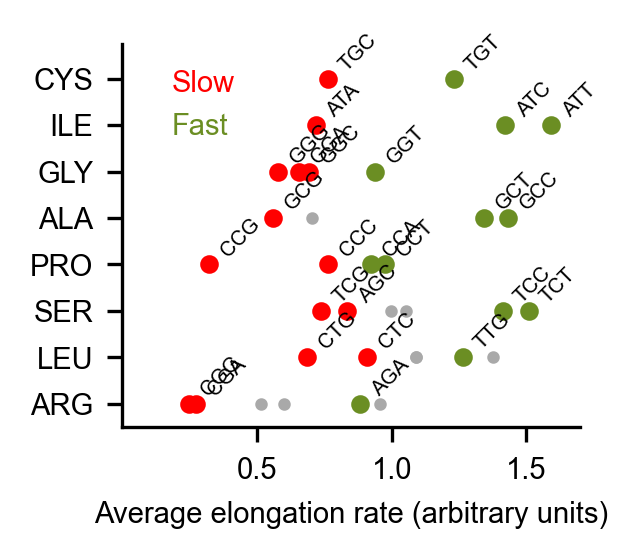

In [10]:
#Figure 2A

#AA used: ALA, ARG, CYS, GLY, ILE, LEU, PRO, SER
#use er (elongation rate) to set codons as slow or fast - threshold = 0.85
#drops codons with intermediate relative er values (0.35<_<0.65)
#drops codons with very inconsistent relative tAI across 14 species (both slow and fast values) - see TODO
#exception made for CTC (LEU) - set as slow
slow_codons = ['GCG','CGA','CGG', 'TCG', 'AGC', 'GGG', 'GGA', 'GGC', 'TGC', 
               'ATA', 'CTC', 'CTG', 'CCG', 'CCC']
fast_codons = ['GCC','GCT', 'AGA', 'TCT', 'TCC', 'GGT', 'TGT', 
               'ATC', 'ATT', 'TTG', 'CCT', 'CCA']
fig, ax = plt.subplots(figsize = (5*cm,4.3*cm))
c = 0

aa_list = ['ALA', 'ARG', 'CYS', 'GLY', 'ILE', 'LEU', 'PRO', 'SER'] 
aa_list.sort(key = (lambda aa: 
                              np.min(codon_info[codon_info.AA==aa].er)))
aa_list.sort(reverse=True, key=(lambda aa:
                                len(codon_info[codon_info.AA==aa].er)))
for aa in aa_list:
    c += 1
    ci_aa = codon_info[codon_info.AA == aa]
    plt.scatter(ci_aa.er, [c]*len(ci_aa.er), color='darkgrey', s=4)
    slow_aa = [x for x in ci_aa.index if x in slow_codons]
    fast_aa = [x for x in ci_aa.index if x in fast_codons]
    slow = plt.scatter(ci_aa.er[slow_aa], [c]*len(slow_aa), color='r', s=12, label='Slow')
    fast = plt.scatter(ci_aa.er[fast_aa], [c]*len(fast_aa), color='olivedrab', s=12, label='Fast')
    for codon in slow_aa+fast_aa:
        plt.annotate(codon, (ci_aa.er[codon], c), rotation=45, xytext=(2, 2), textcoords='offset points', fontsize=5)

handles = [
    mlines.Line2D([],[],color='none', label='Slow'),
    mlines.Line2D([],[],color='none', label='Fast'),

]
plt.legend(handles=handles, loc='upper left', fontsize=7, labelcolor=['r','olivedrab'], frameon=False, handlelength=0)

plt.yticks(np.arange(len(aa_list))+1, aa_list, fontsize=7)
plt.xticks([0.5,1,1.5], fontsize=7)
plt.ylim([0.5, len(aa_list)+0.75])
plt.xlim([0, 1.7])
plt.xlabel("Average elongation rate (arbitrary units)", fontsize=7)
ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'slow_codons.pdf', format='pdf', bbox_inches='tight')
plt.show()

Undersampled model, distribution has weights


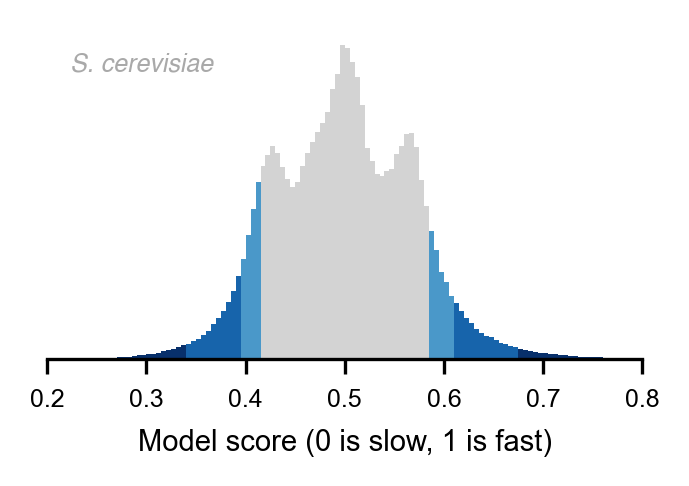

Threshold 0.01 0 to 0.33832267071332084 and 0.6734954739807709 to 1
Threshold 0.05 0.33832267071332084 to 0.3911746975522728 and 0.6079045384753741 to 0.6734954739807709
Threshold 0.1 0.3911746975522728 to 0.41096979375490844 and 0.5838727145289168 to 0.6079045384753741
Threshold (0, 1) 0.09789788 0.88482404
Weighted accuracies for quantiles: 
{'0 to 1%': 0.6930670790187929, '1 to 5%': 0.6128478052156938, '5 to 10%': 0.5775744622068056, 'All': 0.544676763166015}


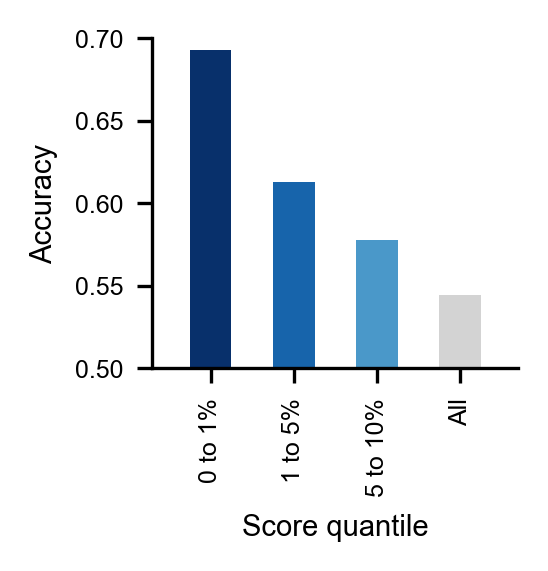

Accuracy is evaluated on a WEIGHTED dataset


In [11]:
#Figure 2F, 2G

r_ = results.model_score
w_ = results.weight
l_ = results.label

fig, ax = plt.subplots(figsize=(6.5*cm,3.7*cm)) 

cmap = mpl.cm.Blues.reversed()
N, bins, patches = plt.hist(r_, bins=120, range=(0.2,0.8), color='lightgrey', weights=w_)
plt.xlabel('Model score (0 is slow, 1 is fast)', fontsize=7)
plt.yticks([],[])
plt.xticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8], fontsize=6)

plt.xlim([0.2, 0.8])
bins = list(bins)
for i in range(len(patches)):
    if bins[i] < weighted_quantile(r_, w_, 0.01) or bins[i] >= weighted_quantile(r_, w_, 0.99):
        patches[i].set_facecolor(cmap(0))
    elif bins[i] < weighted_quantile(r_, w_, 0.05) or bins[i] >= weighted_quantile(r_, w_, 0.95):
        patches[i].set_facecolor(cmap(0.2))
    elif bins[i] < weighted_quantile(r_, w_, 0.1) or bins[i] >= weighted_quantile(r_, w_, 0.9):
        patches[i].set_facecolor(cmap(0.4))


print('Undersampled model, distribution has weights')
ax.spines[['left','right','top']].set_visible(False)

handles = [
    mlines.Line2D([], [], color='none', label='S. cerevisiae')
]
plt.legend(handles = handles, labelcolor='darkgrey', fontsize=6, frameon=False, loc='upper left', markerfirst=False, prop={'family': 'Helvetica', 'style': 'italic', 'size':6})

plt.savefig(fig_dir+'model_score_distribution.pdf', format='pdf', bbox_inches='tight')
plt.show()

q_list = [0.01, 0.05, 0.1, (0,1)]
names = ["0 to 1%", "1 to 5%", "5 to 10%","All"]
colors = [cmap(0),cmap(0.2),cmap(0.4), 'lightgrey']
accuracies = []
for i, q in enumerate(q_list):
    if type(q) == tuple:
        high_th = weighted_quantile(r_, w_, q[1])
        low_th =  weighted_quantile(r_, w_, q[0])
        in_segment = (r_ <= high_th) & (r_ >= low_th)
        print('Threshold', q, low_th, high_th)
    else:
        low_th_end = weighted_quantile(r_, w_, q)
        if i == 0:
            low_th_start = 0
        else:
            low_th_start = weighted_quantile(r_, w_, q_list[i-1])
        in_segment = (r_ <= low_th_end) & (r_ >= low_th_start)
        
        high_th_start = weighted_quantile(r_, w_, 1-q)
        if i == 0:
            high_th_end = 1
        else:
            high_th_end = weighted_quantile(r_, w_, 1-q_list[i-1])
        in_segment = ((r_ <= high_th_end) & (r_ >= high_th_start)) | in_segment
        print('Threshold', q, low_th_start, 'to', low_th_end, 'and', 
              high_th_start, 'to', high_th_end)
    weighted_acc = np.sum( (in_segment & (l_ == (r_ > 0.5))) * w_) / np.sum(w_*in_segment)
    accuracies.append(weighted_acc)

print('Weighted accuracies for quantiles: ')
print({names[i]: accuracies[i] for i in range(len(accuracies))})

fig, ax = plt.subplots(figsize=(4*cm,3.7*cm))

plt.bar(names, accuracies, color=colors, width=0.5)
plt.xticks(fontsize=6, rotation=90)
plt.ylabel('Accuracy', fontsize=7)
plt.ylim((0.5,0.7))
plt.yticks([0.5, 0.55, 0.6, 0.65, 0.7], fontsize=6)
plt.xlim((-0.7, 3.7))
plt.xlabel('Score quantile', fontsize=7)
ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'model_score_quantiles.pdf', format='pdf', bbox_inches='tight')
plt.show()
print('Accuracy is evaluated on a WEIGHTED dataset')

log
unweighted_score
full dataset r=0.46*


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


model_score
balanced r=0.02


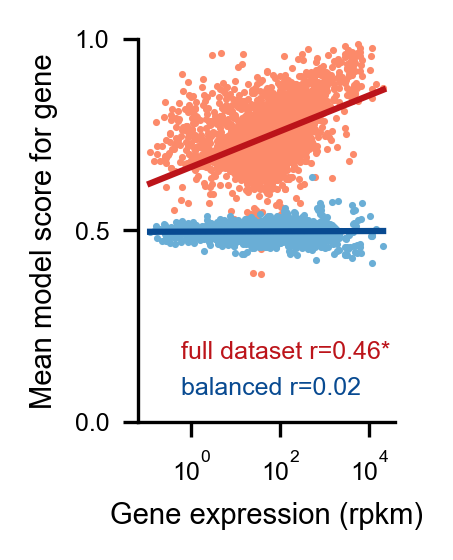

In this case, the full dataset model is evaluated on unweighted S. cerevisiae test set


In [12]:
#Figure 2E
#illustrate that model removes correlation with gene expression
print('log')

blues = plt.get_cmap("Blues")
reds = plt.get_cmap("Reds")
colors = {'model_score':blues, 'unweighted_score':reds}
names = {'model_score':'balanced', 'unweighted_score':'full dataset'}

fig, ax = plt.subplots(figsize=(2.8*cm,4.3*cm))
labels = []
linecolors = []
for m in ['unweighted_score', 'model_score']:
    weighted = (True if m == 'model_score' else False)
    f = lambda group : np.sum(group[m]*group['weight'])/np.sum(group['weight'])
    if not weighted:    
        f = lambda group : np.sum(group[m])/len(group[m])
    mean_scores = results.groupby('gene').apply(f)
    x = mean_scores.index.map(results.drop_duplicates(subset=['gene','gene_rpkm']).set_index('gene').gene_rpkm)
    cond = ~(x.isna() | (x == 0) | mean_scores.isna())
    mean_scores = mean_scores[cond]
    x = x[cond]
    plt.scatter(x, mean_scores, s=0.5, color=colors[m]((0.4 if m == 'unweighted_score' else 0.5)))
    print(m)    
    z = np.polyfit(np.log10(x), mean_scores, 1)
    p = np.poly1d(z)
    pr, p_ = scipy.stats.pearsonr(np.log10(x),  mean_scores)
    
    label = '{n} r={pr:.2f}'.format(n=names[m], pr=pr) + ('*' if m == 'unweighted_score' else '')
    print(label)
    labels.append(label)
    color = colors[m]((0.8 if m == 'unweighted_score' else 0.9))
    linecolors.append(color)
    plt.plot(sorted(x), sorted(p(np.log10(x))), color=color)
    
plt.xlabel('Gene expression (rpkm)', fontsize=7)
plt.ylabel(f'Mean model score for gene', fontsize=7)
plt.xscale('log')


handles = [
    mlines.Line2D([], [], color='none', label=labels[0]), 
    mlines.Line2D([], [], color='none', label=labels[1]), 
]

plt.legend(handles = handles, labelcolor=linecolors,frameon=False,fontsize=6, handlelength=0)

plt.ylim(0,1)
plt.yticks([0, 0.5, 1], fontsize=6)
plt.xticks([1, 100, 10000], fontsize=6)

ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'full_undersampled_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()

print('In this case, the full dataset model is evaluated on unweighted S. cerevisiae test set')

log
r=0.57*


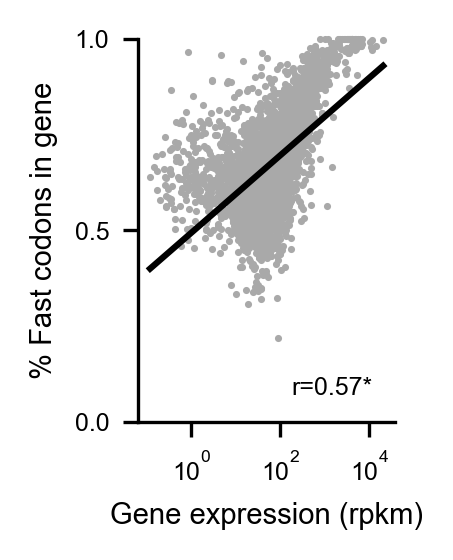

In [13]:
#Figure 2D

weighted = False 
print('log')
fig, ax = plt.subplots(figsize=(2.8*cm,4.3*cm))
m = 'label'
f = lambda group : np.sum(group[m]*group['weight'])/np.sum(group['weight'])
if not weighted:    
    f = lambda group : np.sum(group[m])/len(group[m])
mean_scores = results.groupby('gene').apply(f)
x = mean_scores.index.map(results.drop_duplicates(subset=['gene','gene_rpkm']).set_index('gene').gene_rpkm)
cond = ~(x.isna() | (x == 0) | mean_scores.isna())
mean_scores = mean_scores[cond]
x = x[cond]
plt.scatter(x, mean_scores, s=0.5, color='darkgrey', clip_on=False)
z = np.polyfit(np.log10(x), mean_scores, 1)
p = np.poly1d(z)
pr, p_ = scipy.stats.pearsonr(np.log10(x),  mean_scores)

label = 'r={pr:.2f}'.format(pr=pr)+'*'
print(label)
plt.plot(sorted(x), sorted(p(np.log10(x))), color='black')

plt.xlabel('Gene expression (rpkm)', fontsize=7)
plt.ylabel(f'% Fast codons in gene', fontsize=7)
plt.xscale('log')


handles = [
    mlines.Line2D([], [], color='none', label=label)
]

plt.legend(handles = handles, labelcolor='black',frameon=False,fontsize=6, handlelength=0, loc='lower right')

plt.ylim(0,1)
plt.yticks([0, 0.5, 1], fontsize=6)
plt.xticks([1, 100, 10000], fontsize=6)
ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'gene_expression.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [14]:
#GO analysis - load PANTHER results

#2-10-25-model_wloss
#background set = genes where the sum of weights across positions in the test set is at least 20
#selected set = genes in the bottom 10% of genes in background set by mean weighted model loss

#3-17-25-pool_comp
#background set = genes with fast-to-slow or slow-to-fast variants in pooled competition experiment
#selected set = genes with significant advantageous or deleterious fast-to-slow or slow-to-fast variants (in pooled competition)

#background gene annotations
go_analysis_name = ['2-10-25-model_wloss', '3-17-25-pool_comp']
annotation_sets = ['biological_process', 'molecular_function', 'cellular_component']
background_annotations = {}
for ga_name in go_analysis_name:
    background_annotations[ga_name] = {}
    for a in annotation_sets:
        with open('../data/GO_enrichment/'+ga_name+'/results/bg_'+a+'.json', 'r') as f:
            bg_json = json.load(f)
            for group in bg_json['overrepresentation']['group']:
                if type(group['result']) != list: #turn into a list
                    group['result'] = [group['result']]
                for entry in group['result']:
                    go_term = entry['term']['label']
                    if go_term == 'UNCLASSIFIED':
                        continue #skip this term
                    genes = entry['input_list']['mapped_id_list']['mapped_id']
                    if type(genes) != list:
                        genes = [genes] #genes should be a list, even if there's only one
                    if go_term in background_annotations[ga_name].keys():
                        print(go_term, a, ga_name, group, entry)
                        raise ValueError() #should only have one entry for each term
                    else:
                        background_annotations[ga_name][go_term] = genes  

In [15]:
#load the PANTHER analysis
go_analysis_name = ['2-10-25-model_wloss','3-17-25-pool_comp']
annotation_sets = ['biological_process', 'molecular_function', 'cellular_component']
go_analysis = {}
for ga_name in go_analysis_name:
    print(ga_name)
    go_analysis[ga_name] = {}
    for a in annotation_sets:
        with open('../data/GO_enrichment/'+ga_name+'/results/analysis_'+a+'.json', 'r') as f:
            bg_json = json.load(f)
            for g_i, group in enumerate(bg_json['overrepresentation']['group']):
                if type(group['result']) != list: #turn into a list
                    group['result'] = [group['result']]
                for entry in group['result']:
                    go_term = entry['term']['label']
                    if go_term == 'UNCLASSIFIED':
                        continue #skip this term
                    if 'mapped_id_list' in entry['input_list']:
                        genes = entry['input_list']['mapped_id_list']['mapped_id']
                    else:
                        genes = [] #there were no genes
                    if type(genes) != list:
                        genes = [genes] #genes should be a list, even if there's only one
                    if go_term in go_analysis[ga_name].keys():
                        raise ValueError() #should only have one entry for each term
                    info = {}
                    info['number_in_reference'] = entry['number_in_reference']
                    for x in ['number_in_list','fold_enrichment', 'fdr', 'expected', 'pValue', 'plus_minus']:
                        info[x] = entry['input_list'][x]
                    for x in ['level','id','label']:
                        info[x] = entry['term'][x]
                    info['genes'] = genes
                    info['reference_genes'] = background_annotations[ga_name][go_term]
                    info['annotation_set'] = a
                    info['group'] = a[0] + str(g_i) #so we can later sort by group
                    go_analysis[ga_name][go_term] = info
    go_analysis[ga_name] = pd.DataFrame(go_analysis[ga_name]).T
go_analysis[go_analysis_name[0]]

2-10-25-model_wloss
3-17-25-pool_comp


,number_in_reference,number_in_list,fold_enrichment,fdr,expected,pValue,plus_minus,level,id,label,genes,reference_genes,annotation_set,group
GMP biosynthetic process,7,5,6.7887,0.0199529,0.736518,0.00022165,+,0,GO:0006177,GMP biosynthetic process,"[YNL333W, YHR216W, YLR432W, YMR217W, YJR133W]","[YNL333W, YHR216W, YDR399W, YLR432W, YMR217W, ...",biological_process,b0
purine ribonucleotide biosynthetic process,30,10,3.16806,0.0365018,3.1565,0.000648776,+,1,GO:0009152,purine ribonucleotide biosynthetic process,"[YGR061C, YDL185W, YNL333W, YHR216W, YLR432W, ...","[YHR216W, YAR015W, YKL016C, YJL005W, YNL333W, ...",biological_process,b0
biosynthetic process,1655,242,1.38974,1.10452e-07,174.134,2.45394e-11,+,4,GO:0009058,biosynthetic process,"[YDR297W, YPR016C, YDR188W, YNL064C, YER125W, ...","[YHR208W, YER007C-A, YAL062W, YML010W, YBR055C...",biological_process,b0
metabolic process,2697,333,1.17349,0.000572415,283.77,1.0174e-06,+,5,GO:0008152,metabolic process,"[YDR297W, YPR016C, YDR188W, YNL064C, YER125W, ...","[YPR180W, YJR120W, YHR208W, YER007C-A, YLR308W...",biological_process,b0
cellular process,4002,452,1.07344,0.00044002,421.078,6.84323e-07,+,6,GO:0009987,cellular process,"[YPR192W, YGR029W, YOL080C, YCR027C, YNR002C, ...","[YPR180W, YJR120W, YHR208W, YER007C-A, YOR338W...",biological_process,b0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mitochondrial inner membrane,192,37,1.83154,0.0298345,20.2016,0.000250185,+,0,GO:0005743,mitochondrial inner membrane,"[YMR038C, YOR271C, YKR042W, YBR244W, YOR037W, ...","[YGR021W, YPL215W, YMR038C, YMR301C, YBR244W, ...",cellular_component,c3
organelle inner membrane,206,38,1.7532,0.0407541,21.6747,0.000427192,+,1,GO:0019866,organelle inner membrane,"[YMR038C, YOR271C, YKR042W, YBR244W, YOR037W, ...","[YPL215W, YMR301C, YNL008C, YER017C, YKR065C, ...",cellular_component,c3
nucleolus,247,43,1.65457,0.0472121,25.9886,0.000841307,+,0,GO:0005730,nucleolus,"[YJR063W, YCR057C, YPR016C, YNL175C, YGR271C-A...","[YPR016C, YNR038W, YNL075W, YOL080C, YGR280C, ...",cellular_component,c4
nuclear protein-containing complex,539,35,0.617155,0.0444391,56.7119,0.00074531,-,0,GO:0140513,nuclear protein-containing complex,"[YJR063W, YCR057C, YOR340C, YOL123W, YER127W, ...","[YPR180W, YNL008C, YOR326W, YFL003C, YOR229W, ...",cellular_component,c5


In [16]:
#pruning GO terms - genes with lowest 10% model loss
#too many GO terms - need to narrow done a set to display in figures
enriched_terms_db = go_analysis['2-10-25-model_wloss']
#look only at GO terms with a fold enrichment of 2 among low model loss genes
best_go_terms = enriched_terms_db[(enriched_terms_db.fold_enrichment >= 2)].index

best_go_terms_db = enriched_terms_db[enriched_terms_db.index.isin(best_go_terms)].copy()
                
#aggresive prune means we remove any term if the term has a parent or child with a better p-value
best_go_terms_db['aggresive_prune'] = False
for i in best_go_terms_db.index: 
    go_id = best_go_terms_db.id[i]
    parents = go_dag[go_id]._parents
    i_fe = best_go_terms_db.fold_enrichment[i]
    i_pval = best_go_terms_db.pValue[i]
    for p in parents:
        if p in list(best_go_terms_db['id']):
            p = best_go_terms_db.set_index('id').label[p]
            p_fe = best_go_terms_db.fold_enrichment[p]
            p_pval = best_go_terms_db.pValue[p]
            if p_pval >= i_pval:
                best_go_terms_db.aggresive_prune[p] = True 
            elif p_pval < i_pval:
                best_go_terms_db.aggresive_prune[i] = True

#additional redundant terms to remove, after pruning (hand-picked)
terms_to_remove = ['nucleoside phosphate metabolic process', 'organic cation transport', 'amino acid transport', 'maturation of SSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)',
                  'organic cation transmembrane transporter activity', 'organic anion transmembrane transporter activity', 'monoatomic ion transmembrane transporter activity', 'inorganic cation transmembrane transporter activity'
                  ]

pruned_terms = best_go_terms_db[(~best_go_terms_db.aggresive_prune) & (~best_go_terms_db.index.isin(terms_to_remove))]
print('all enriched terms:', len(enriched_terms_db))
print('best (fold enrichment > 2):', len(best_go_terms))
print('pruned terms:', len(pruned_terms))
pruned_terms

all enriched terms: 156
best (fold enrichment > 2): 74
pruned terms: 26


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,number_in_reference,number_in_list,fold_enrichment,fdr,expected,pValue,plus_minus,level,id,label,genes,reference_genes,annotation_set,group,aggresive_prune
GMP biosynthetic process,7,5,6.7887,0.0199529,0.736518,0.00022165,+,0,GO:0006177,GMP biosynthetic process,"[YNL333W, YHR216W, YLR432W, YMR217W, YJR133W]","[YNL333W, YHR216W, YDR399W, YLR432W, YMR217W, ...",biological_process,b0,False
purine-containing compound metabolic process,143,34,2.25974,0.00147239,15.046,4.57977e-06,+,4,GO:0072521,purine-containing compound metabolic process,"[YMR303C, YHR216W, YCR073W-A, YBR145W, YFR053C...","[YOR095C, YEL041W, YLR231C, YCL040W, YJL005W, ...",biological_process,b0,False
regulation of proteolysis,19,8,4.00176,0.0271756,1.99912,0.000374336,+,1,GO:0030162,regulation of proteolysis,"[YKL145W, YDL007W, YGR231C, YGR132C, YER125W, ...","[YBL057C, YLR178C, YJR017C, YGL116W, YER125W, ...",biological_process,b1,False
protein folding,106,26,2.33121,0.0050876,11.153,3.05188e-05,+,3,GO:0006457,protein folding,"[YDR188W, YNL064C, YDL100C, YER103W, YIL027C, ...","[YDR188W, YGR211W, YDR533C, YNL064C, YJR051W, ...",biological_process,b2,False
tRNA aminoacylation for protein translation,37,15,3.85305,0.000811891,3.89302,1.8038e-06,+,0,GO:0006418,tRNA aminoacylation for protein translation,"[YIL078W, YDR023W, YDR268W, YLL018C, YPR033C, ...","[YIL078W, YPL104W, YDR023W, YLR382C, YDR037W, ...",biological_process,b3,False
translation,193,47,2.31449,1.93241e-05,20.3068,2.14665e-08,+,1,GO:0006412,translation,"[YIL078W, YPR016C, YNL175C, YPL237W, YGR162W, ...","[YPL118W, YKL155C, YPR016C, YNL185C, YML091C, ...",biological_process,b3,False
pyruvate metabolic process,23,9,3.71903,0.0249052,2.41999,0.000309862,+,0,GO:0006090,pyruvate metabolic process,"[YDR516C, YMR205C, YGL062W, YGR240C, YLR153C, ...","[YDR516C, YMR205C, YOL056W, YLR153C, YFL018C, ...",biological_process,b4,False
alcohol metabolic process,105,26,2.35342,0.00473814,11.0478,2.73699e-05,+,1,GO:0006066,alcohol metabolic process,"[YMR303C, YBR145W, YBR149W, YNL333W, YIL102C-A...","[YOR136W, YOR163W, YIL102C-A, YOR245C, YML075C...",biological_process,b5,False
protein targeting to ER,31,11,3.37245,0.0177873,3.26172,0.000185737,+,0,GO:0045047,protein targeting to ER,"[YDR292C, YML105C, YNL064C, YJL034W, YLR378C, ...","[YOR164C, YPR088C, YNL064C, YAL015C, YDL100C, ...",biological_process,b7,False
transmembrane transport,397,84,2.01096,1.19989e-07,41.7711,5.33165e-11,+,2,GO:0055085,transmembrane transport,"[YDR011W, YNL121C, YPR192W, YOR192C, YJR152W, ...","[YPR192W, YEL065W, YDR205W, YGR029W, YIL166C, ...",biological_process,b9,False


{'cellular_component': 3, 'molecular_function': 9, 'biological_process': 14}


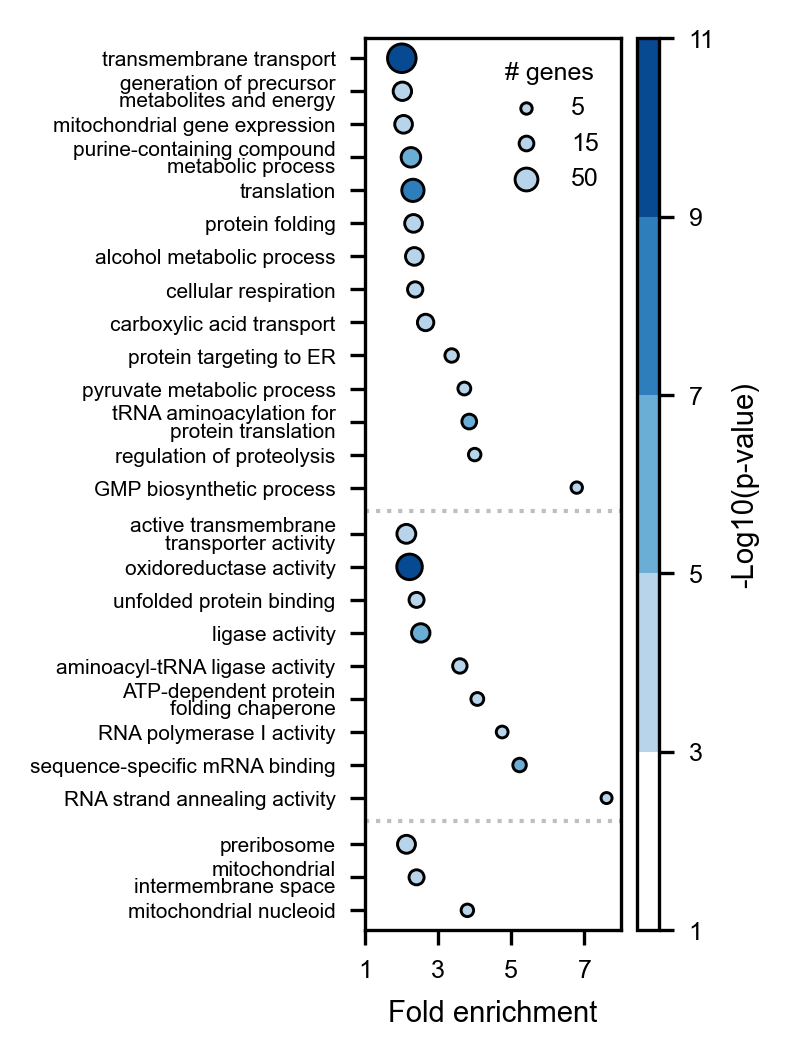

In [17]:
#Figure 3G
df_list = []
annotation_set_names = ['cellular_component', 'molecular_function','biological_process']
as_counts = {}
for annotation_set in annotation_set_names:
    df_ = pruned_terms[pruned_terms.annotation_set == annotation_set].sort_values(by = 'fold_enrichment', ascending=False)
    as_counts[annotation_set] = len(df_)
    df_list.append(df_)
df = pd.concat(df_list)

y = 'label'
x = 'fold_enrichment'
z = 'pValue'
w = 'number_in_list'

df[x] = df[x].astype(float)
df[z] = df[z].astype(float)
df[w] = df[w].astype(int)

size_f = lambda x:x/2+5


fig, ax = plt.subplots(figsize=(3.5*cm, 10*cm))

#gaps between the categories
y_positions = []
c = 0
for a in annotation_set_names:
    y_positions += list(np.linspace(c, c+as_counts[a]-1, num=as_counts[a]))
    c+= as_counts[a] + 0.4
    ax.axhline(c - 0.7, color='gray', alpha=0.5,
                   linestyle=':', 
                   linewidth=1)

print(as_counts)

blues = plt.get_cmap("Blues")
cmaplist = ["white",  blues(0.3), blues(0.5), blues(0.7),blues(0.9)] 
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, len(cmaplist))

bounds = [1,3,5,7,9,11]  
assert(len(bounds) == len(cmaplist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds)-1)

sm = ScalarMappable(norm=norm, cmap=cmap)


edgecolors = np.array(['black']*len(df[z])).astype('object')
edgecolors[df[z] > 0.05] = 'darkgrey'

scatter = plt.scatter(
    df[x], y_positions, s=size_f(df[w]), 
    c=-np.log10(df[z]), cmap=cmap, 
    norm=norm, edgecolors=edgecolors, linewidths=0.7,
)


plt.xticks([1,3,5,7],fontsize=6)

plt.ylim(min(y_positions)-0.6, max(y_positions)+0.6)
ax.set_yticks(y_positions)

namechange = {'generation of precursor metabolites and energy':'generation of precursor\nmetabolites and energy',
             'purine-containing compound metabolic process':'purine-containing compound\nmetabolic process',
             'tRNA aminoacylation for protein translation':'tRNA aminoacylation for\nprotein translation',
             'active transmembrane transporter activity':'active transmembrane\ntransporter activity',
             'ATP-dependent protein folding chaperone':'ATP-dependent protein\nfolding chaperone',
             'mitochondrial intermembrane space':'mitochondrial\nintermembrane space'}
yticklabels = [namechange[g] if g in namechange else g for g in df[y]]


ax.set_yticklabels(yticklabels, fontsize=5, linespacing=0.9)
ax.set_xlabel('Fold enrichment', fontsize=7)

cbar = plt.colorbar(sm, ticks=bounds, boundaries=bounds, ax=ax, orientation='vertical', aspect=40)
cbar.ax.tick_params(labelsize=6)
cbar.set_label('-Log10(p-value)', fontsize=7)

#size legend
for size in [5, 15, 50]:
    ax.scatter([], [], s=size_f(size), 
               color=cmap(norm(4)), 
               #color = 'tab:blue',
               edgecolor='black',  label=f'{size}', lw=0.7)
ax.legend(scatterpoints=1, frameon=False,  title='# genes', title_fontsize=6, fontsize=6)


plt.xlim(1,8)
plt.savefig(fig_dir + 'model_GO_terms_long.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [18]:
#Looking at positions inside various protein features
inside_feature_stats = {}
feature_names = ['Region:Disordered','Signal or transit peptide', 
                    'Binding or active site', 'Transmembrane', 'Topological domain:Extracellular',
                    'Topological domain:Cytoplasmic',  'pfam domain']

def get_stats(cond, results):
    r_ = results.model_score
    g_ = results.gene
    w_ = results.weight
    l_ = results.label
    stats = {}
    stats['num_genes'] = len(np.unique(g_[cond]))
    stats['num_codons'] = np.sum(cond)
    stats['wloss'] = crossentropy(l_[cond], r_[cond], w_[cond])
    for weighted in [True, False]:
        weight = w_[cond] if weighted else None
        prefix = 'weighted_' if weighted else ''
        stats[prefix + 'percent_fast'] = weighted_average(l_[cond], weight)
        stats[prefix + 'percent_pred_fast'] =  weighted_average(r_[cond] > 0.5, weight)
        stats[prefix + 'mean_score'] = weighted_average(r_[cond], weight)
        stats[prefix + 'acc'] = weighted_average(l_[cond] == (r_[cond] > 0.5), weight)
        stats[prefix + 'auc'] =  auc(l_[cond] , r_[cond], weights=weight)
    return stats

for feature in ['all'] + feature_names:
    print(feature)
    if feature != 'all':
        cond = positions_in_feature[feature]
    else:
        cond = np.ones(len(results.gene)).astype(bool)
    inside_feature_stats[feature] = get_stats(cond, results)
    if feature != 'all':
        #for ttest, compare to positions outside of feature
        s1 = results.model_score[cond]
        w1 =  results.weight[cond]  
        s2 =  results.model_score[~cond]
        w2 = results.weight[~cond]
        wm1 = np.sum(s1*w1)/np.sum(w1)
        inside_feature_stats[feature]['weighted_mean_inside'] = wm1
        tstat, pval, df = smw.ttest_ind( s1, s2, usevar='unequal', weights=(w1,w2))
        inside_feature_stats[feature]['ttest_score_v_other_tstat'] = tstat
        inside_feature_stats[feature]['ttest_score_v_other_pval'] = pval
        pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
        wm2 = np.sum(s2*w2)/np.sum(w2)
        inside_feature_stats[feature]['weighted_mean_other'] = wm2
        inside_feature_stats[feature]['pool_w_other_stdev'] = pool_stdev
        inside_feature_stats[feature]['effect_size_v_other'] = np.abs(wm1 - wm2)/pool_stdev

inside_feature_stats = pd.DataFrame(inside_feature_stats).T

all
Region:Disordered
Signal or transit peptide
Binding or active site
Transmembrane
Topological domain:Extracellular
Topological domain:Cytoplasmic
pfam domain


In [19]:
inside_feature_stats

,num_genes,num_codons,wloss,weighted_percent_fast,weighted_percent_pred_fast,weighted_mean_score,weighted_acc,weighted_auc,percent_fast,percent_pred_fast,mean_score,acc,auc,weighted_mean_inside,ttest_score_v_other_tstat,ttest_score_v_other_pval,weighted_mean_other,pool_w_other_stdev,effect_size_v_other
all,5897.0,893586.0,0.686589,0.500000,0.489634,0.498453,0.544677,0.563918,0.675449,0.515928,0.502718,0.557482,0.580630,NaN,NaN,NaN,NaN,NaN,NaN
Region:Disordered,2615.0,87284.0,0.684436,0.479250,0.381445,0.478094,0.550405,0.568335,0.642603,0.425003,0.484957,0.550376,0.610920,0.478094,-75.058319,0.000000e+00,0.500780,0.069947,0.324323
Signal or transit peptide,587.0,6191.0,0.674305,0.425249,0.127520,0.416086,0.577110,0.575496,0.661121,0.176870,0.426900,0.438217,0.595424,0.416086,-66.682719,0.000000e+00,0.498980,0.069976,1.184616
Binding or active site,1266.0,6247.0,0.669696,0.562699,0.716566,0.556681,0.571853,0.596152,0.710101,0.733312,0.559852,0.636786,0.584237,0.556681,35.180199,5.211567e-231,0.498065,0.070124,0.835875
Transmembrane,1140.0,48895.0,0.684326,0.511562,0.497842,0.502520,0.552979,0.576589,0.678740,0.517517,0.506007,0.556621,0.579530,0.502520,8.465892,2.656034e-17,0.498216,0.070278,0.061242
Topological domain:Extracellular,294.0,15552.0,0.686917,0.499792,0.514274,0.502066,0.545837,0.564994,0.663387,0.537744,0.506111,0.564686,0.579808,0.502066,4.610852,4.063100e-06,0.498386,0.070284,0.052348
Topological domain:Cytoplasmic,726.0,52284.0,0.682661,0.492837,0.464267,0.493457,0.554661,0.579903,0.678372,0.497896,0.499242,0.559904,0.596554,0.493457,-11.852644,2.428340e-32,0.498764,0.070274,0.075513
pfam domain,4850.0,421510.0,0.685643,0.510389,0.553596,0.510572,0.546621,0.567806,0.703177,0.574378,0.514160,0.574615,0.573999,0.510572,108.041922,0.000000e+00,0.488896,0.069456,0.312078


                                                           feature  num_codons  weighted_mean_score  effect_size_v_other
Signal or transit peptide                Signal or transit peptide      6191.0             0.416086             1.184616
Region:Disordered                                Region:Disordered     87284.0             0.478094             0.324323
Topological domain:Cytoplasmic      Topological domain:Cytoplasmic     52284.0             0.493457             0.075513
Topological domain:Extracellular  Topological domain:Extracellular     15552.0             0.502066             0.052348
Transmembrane                                        Transmembrane     48895.0             0.502520             0.061242
pfam domain                                            pfam domain    421510.0             0.510572             0.312078
Binding or active site                      Binding or active site      6247.0             0.556681             0.835875

Empty circles mean effect size 

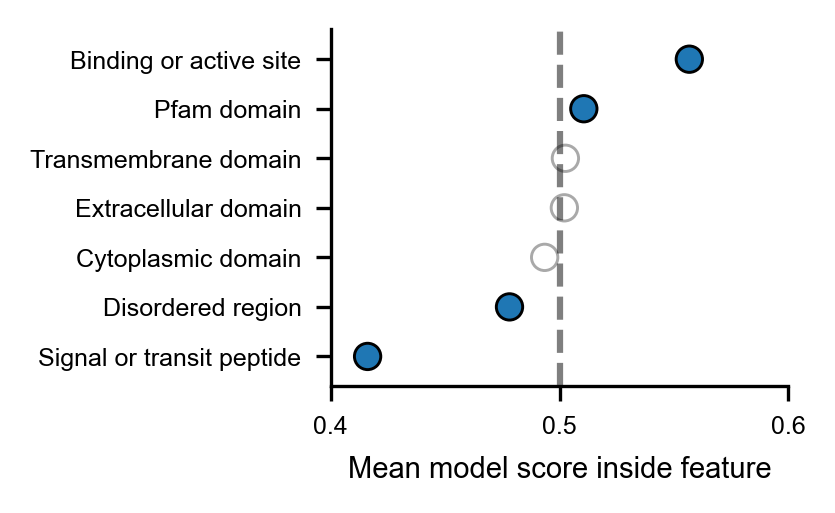

In [20]:
#Figure 3C
stat_names = {'weighted_acc':'Accuracy (weighted)', 
              'auc':'AUC', 'weighted_percent_fast':'% fast codons (weighted)', 
              'weighted_percent_pred_fast':'% fast predicted (weighted)',
              'weighted_mean_score':'mean model score for positions inside feature (weighted)'}

stat = 'weighted_mean_score'
max_log_pval = 11
df = inside_feature_stats.sort_values(by = stat).drop(['all'])
df['feature'] = df.index
df.replace(np.inf, max_log_pval, inplace=True)

y = 'feature'
x = stat
z = 'effect_size_v_other'
w = 'num_codons'
min_z = 0.3

print(df[[y,w,x,z]].to_string())

fig, ax = plt.subplots(figsize=(5*cm, 4*cm))
y_positions = range(len(df[y]))

edgecolors = np.array(['black']*len(df[z])).astype('object')
edgecolors[df[z] < min_z] = 'darkgrey'
print('\nEmpty circles mean effect size is less than 0.3')

ax.axvline(0.5, c='black', linestyle='dashed', alpha=0.5)

colors = np.array(['tab:blue']*len(df[z])).astype('object')
colors[df[z] < min_z] = 'white'
scatter = ax.scatter(
    (df[x]), y_positions, 
    s=40,
    c=colors,
    norm=norm, edgecolor=edgecolors, lw=0.7,
)

feature_names = {'Binding or active site':'Binding or active site', 
                 'multiple pfam domain':'Pfam multi-domain',
                 'pfam domain':'Pfam domain', 
                 'Transmembrane':'Transmembrane domain', 
                 'Topological domain:Extracellular':'Extracellular domain',
                 'Topological domain:Cytoplasmic':'Cytoplasmic domain',
                 'Region:Disordered':'Disordered region', 
                'Signal or transit peptide':'Signal or transit peptide'}


ax.set_yticks(y_positions)
plt.ylim((min(y_positions) - 0.6, max(y_positions) + 0.6))
ax.set_yticklabels([feature_names[f] for f in df[y]], fontsize=6)
ax.set_xticks([0.4,0.5,0.6])
ax.set_xticklabels([0.4,0.5,0.6], fontsize=6)
ax.set_xlabel('Mean model score inside feature', fontsize=7)
plt.xlim(min(0.5, min(df[x])-0.02), max(df[x])+0.02)
plt.xlim(0.4, 0.6)
prefix = '' if stat == 'weighted_mean_score' else 'supp_'
ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'model_mean_score_inside_feature.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [21]:
#are the first 50 positions significantly slower than the rest?
#use welch's t-test
cond = results.position < 50
print('Weighted mean score first 50 codons',  np.sum(results.model_score[cond] * results.weight[cond]) / np.sum(results.weight[cond]))
print('Weighted mean score of codons excluding first 50', np.sum(results.model_score[~cond] * results.weight[~cond]) / np.sum(results.weight[~cond]))
tstat, pval, df = smw.ttest_ind( results.model_score[cond], results.model_score[~cond], usevar='unequal',
                              weights=(results.weight[cond], results.weight[~cond]))
print('Weighted Welchs ttest tstat', tstat, 'p-value', pval, 'degrees of freedom', df)
wm1 = np.sum(results.model_score[cond] * results.weight[cond]) / np.sum(results.weight[cond])
wm2 = np.sum(results.model_score[~cond] * results.weight[~cond]) / np.sum(results.weight[~cond])
pool_stdev = weighted_pooled_stdev(results.model_score[cond], results.weight[cond],
                                  results.model_score[~cond], results.weight[~cond])
print(wm1, wm2, pool_stdev)
print('Effect size: ', np.abs(wm1 - wm2)/pool_stdev)
print()

print()
print('We find the same pattern for each amino acid, to varying extents:')
per_aa_db = {}
for aa in ['CYS','PRO','ARG','ALA','GLY', 'SER', 'ILE', 'LEU']:
    bg = results.AA == aa
    cond = results.position < 50
    per_aa_db[aa] = {}
    s1 = results.model_score[bg&cond]
    s2 =  results.model_score[bg&(~cond)]
    w1 =  results.weight[bg&cond]
    w2 = results.weight[bg&(~cond)]
    wm1 = np.sum(s1*w1)/np.sum(w1)
    wm2 = np.sum(s2*w2)/np.sum(w2)
    per_aa_db[aa]['mean_weighted_score_first_50_pos'] = wm1
    per_aa_db[aa]['mean_weighted_score_after_50_pos'] = wm2
    tstat, pval, df = smw.ttest_ind( s1, s2, usevar='unequal', weights=(w1,w2))
    per_aa_db[aa]['weighted_welchs_ttest_tstat'] = tstat
    per_aa_db[aa]['weighted_welchs_ttest_p-value'] = pval
    per_aa_db[aa]['weighted_welchs_ttest_df'] = df
    pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
    per_aa_db[aa]['effect_size'] = np.abs(wm1 - wm2)/pool_stdev
    
per_aa_db = pd.DataFrame(per_aa_db).T
per_aa_db

Weighted mean score first 50 codons 0.464945695730273
Weighted mean score of codons excluding first 50 0.502582725389086
Weighted Welchs ttest tstat -117.02795596809126 p-value 0.0 degrees of freedom 68440.22693074596
0.464945695730273 0.502582725389086 0.0692939006753531
Effect size:  0.5431506855869636


We find the same pattern for each amino acid, to varying extents:


,mean_weighted_score_first_50_pos,mean_weighted_score_after_50_pos,weighted_welchs_ttest_tstat,weighted_welchs_ttest_p-value,weighted_welchs_ttest_df,effect_size
CYS,0.467743,0.498986,-19.404124,1.490146e-78,2660.367758,0.467424
PRO,0.473831,0.502377,-43.601773,0.000000e+00,9308.972217,0.572062
ARG,0.437181,0.507063,-49.689277,0.000000e+00,4166.102553,0.942755
ALA,0.474715,0.508086,-30.420016,4.640490e-186,4812.274958,0.539318
GLY,0.466858,0.498851,-30.518712,1.287805e-196,11268.127992,0.336957
SER,0.470564,0.501534,-53.599064,0.000000e+00,14467.171716,0.552383
ILE,0.460452,0.502996,-54.727749,0.000000e+00,11579.279112,0.615817
LEU,0.457486,0.505185,-59.880321,0.000000e+00,9877.878882,0.755959


In [22]:
#are starting positions in genes with signal and transit peptides significantly slower than starting positions in other genes?
print('Comparing first 50 codons in genes with signal/transit peptides vs. first 50 codons in genes with no signal or transit peptide')
bg = results.position < 50
peptide_genes = pd.concat((get_protein_type(protein_db, "Signal peptide").gene, get_protein_type(protein_db, "Transit peptide").gene))
cond = results.gene.isin(peptide_genes) 
print(f'Signal/transit peptide: Weighted mean score first 50 codons',  np.sum(results.model_score[cond & bg] * results.weight[cond & bg]) / np.sum(results.weight[cond & bg]))
print(f'NOT Signal/transit peptide: Weighted mean score first 50 codons', np.sum(results.model_score[(~cond) & bg] * results.weight[(~cond)&bg]) / np.sum(results.weight[(~cond)&bg]))
tstat, pval, df = smw.ttest_ind( results.model_score[cond&bg], results.model_score[(~cond)&bg], usevar='unequal',
                              weights=(results.weight[cond&bg], results.weight[(~cond)&bg]))
print(f'Weighted Welchs ttest tstat', tstat, 'p-value', pval, 'degrees of freedom', df)
s1 = results.model_score[bg&cond]
s2 =  results.model_score[bg&(~cond)]
w1 =  results.weight[bg&cond]
w2 = results.weight[bg&(~cond)]
wm1 = np.sum(s1*w1)/np.sum(w1)
wm2 = np.sum(s2*w2)/np.sum(w2)
pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
print('Effect size: ', np.abs(wm1 - wm2)/pool_stdev)
print()
print()
print('We find the same pattern for each amino acid, to varying extents:')
per_aa_db = {}
for aa in ['all AA','CYS','PRO','ARG','ALA','GLY', 'SER', 'ILE', 'LEU']:
    if aa == 'all AA':
        bg = (results.position < 50)
    else:
        bg = (results.AA == aa) & (results.position < 50)
    cond =  results.gene.isin(peptide_genes) 
    per_aa_db[aa] = {}
    s1 = results.model_score[bg&cond]
    s2 =  results.model_score[bg&(~cond)]
    w1 =  results.weight[bg&cond]
    w2 = results.weight[bg&(~cond)]
    wm1 = np.sum(s1*w1)/np.sum(w1)
    wm2 = np.sum(s2*w2)/np.sum(w2)
    per_aa_db[aa]['mean_weighted_score_first_50_pos_peptide'] = wm1
    per_aa_db[aa]['mean_weighted_score_first_50_pos_not_peptide'] = wm2
    tstat, pval, df = smw.ttest_ind( s1, s2, usevar='unequal',weights=(w1, w2))
    per_aa_db[aa]['weighted_welchs_ttest_tstat'] = tstat
    per_aa_db[aa]['weighted_welchs_ttest_p-value'] = pval
    per_aa_db[aa]['weighted_welchs_ttest_df'] = df
    pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
    per_aa_db[aa]['effect_size'] = np.abs(wm1 - wm2)/pool_stdev
per_aa_db = pd.DataFrame(per_aa_db).T
per_aa_db

Comparing first 50 codons in genes with signal/transit peptides vs. first 50 codons in genes with no signal or transit peptide
Signal/transit peptide: Weighted mean score first 50 codons 0.43789926752760705
NOT Signal/transit peptide: Weighted mean score first 50 codons 0.4680215142953459
Weighted Welchs ttest tstat -28.494125489591973 p-value 8.664382204253908e-169 degrees of freedom 6788.2479533733695
Effect size:  0.4244288354719911


We find the same pattern for each amino acid, to varying extents:


,mean_weighted_score_first_50_pos_peptide,mean_weighted_score_first_50_pos_not_peptide,weighted_welchs_ttest_tstat,weighted_welchs_ttest_p-value,weighted_welchs_ttest_df,effect_size
all AA,0.437899,0.468022,-28.494125,8.664382e-169,6788.247953,0.424429
CYS,0.433932,0.472549,-7.823631,6.536491e-14,340.133577,0.543970
PRO,0.468147,0.474399,-2.745515,6.175711e-03,808.643702,0.116085
ARG,0.415131,0.440193,-6.035557,3.169857e-09,480.409512,0.340896
ALA,0.466394,0.475743,-2.753053,6.109182e-03,523.770856,0.145725
GLY,0.444342,0.469019,-6.977060,5.618284e-12,958.125628,0.259858
SER,0.448690,0.473053,-13.396580,1.194849e-38,1435.551434,0.421063
ILE,0.413391,0.465440,-19.299166,1.695130e-71,1075.788291,0.734963
LEU,0.419230,0.462660,-17.907568,7.234171e-64,1222.450428,0.642225


In [23]:
#Unused Supplementary Table
peptide_per_aa_db = per_aa_db
keep_cols = {'mean_weighted_score_first_50_pos_peptide':"Mean score at start for peptide genes",
            'mean_weighted_score_first_50_pos_not_peptide':"Mean score at start for other genes",
             'weighted_welchs_ttest_tstat':'T-statistic',
             'weighted_welchs_ttest_p-value':"P-value", 
             'effect_size':'Effect size'}
peptide_per_aa_db = peptide_per_aa_db.rename(columns=keep_cols)[list(keep_cols.values())]
#peptide_per_aa_db.round(decimals=2)
peptide_per_aa_db

,Mean score at start for peptide genes,Mean score at start for other genes,T-statistic,P-value,Effect size
all AA,0.437899,0.468022,-28.494125,8.664382e-169,0.424429
CYS,0.433932,0.472549,-7.823631,6.536491e-14,0.543970
PRO,0.468147,0.474399,-2.745515,6.175711e-03,0.116085
ARG,0.415131,0.440193,-6.035557,3.169857e-09,0.340896
ALA,0.466394,0.475743,-2.753053,6.109182e-03,0.145725
GLY,0.444342,0.469019,-6.977060,5.618284e-12,0.259858
SER,0.448690,0.473053,-13.396580,1.194849e-38,0.421063
ILE,0.413391,0.465440,-19.299166,1.695130e-71,0.734963
LEU,0.419230,0.462660,-17.907568,7.234171e-64,0.642225


In [24]:
print("Mean model score inside of signal or transit peptide")
cond = positions_in_feature['Signal or transit peptide']
print(f'Inside signal/transit peptide: Weighted mean score',  np.sum(results.model_score[cond] * results.weight[cond]) / np.sum(results.weight[cond]))

Mean model score inside of signal or transit peptide
Inside signal/transit peptide: Weighted mean score 0.4160862196787373


With peptide minimum at pos: 14 value: 0.39929991319739105
x [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
pred [0.41489538 0.43052485 0.44295073 0.40932381 0.40969308 0.41597569
 0.40974001 0.40521594 0.40414009 0.40316817 0.40188006 0.4137794
 0.40019748 0.39929991 0.40422789 0.41483139 0.40902682 0.41546737
 0.43039667 0.4378247  0.43176101 0.43389251 0.44808846 0.43803629
 0.45217209 0.44748861 0.446821   0.45581631 0.45048315 0.44980852]
Average number of positions in first 50 in signal/transit peptides 220.24


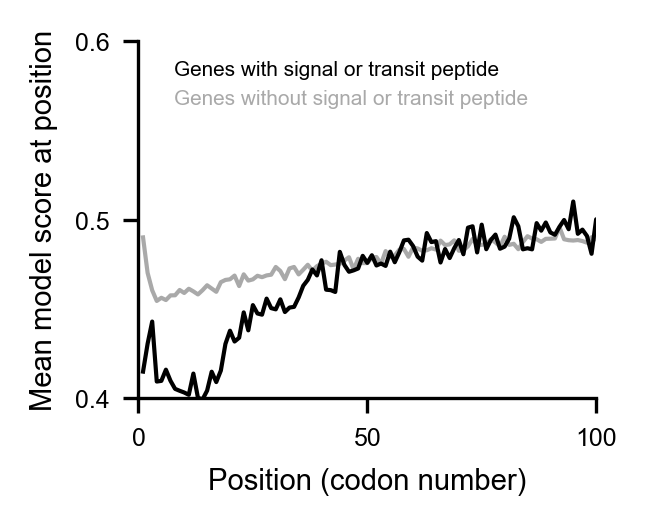

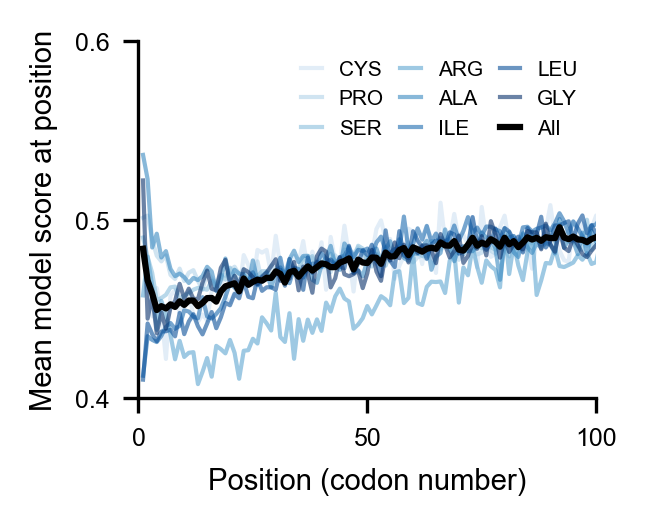

In [25]:
#Figure 3B, Figure 3A
fig, ax = plt.subplots(figsize=(5*cm,4*cm))
bg = True
cond = results.gene.isin(protein_db[protein_db.type.isin(['Signal peptide', 'Transit peptide'])].gene.unique()) 
x, pred, counts = mean_for_vals_at_pos(results.model_score[bg & (~cond)], results.position[bg & (~cond)], weights=results.weight[bg & (~cond)])
plt.plot(x, pred, label='Genes without signal or transit peptide', linewidth=1, 
         color='darkgrey')
x, pred, counts = mean_for_vals_at_pos(results.model_score[bg & (cond)], results.position[bg & (cond)], weights=results.weight[bg & (cond)])
plt.plot(x, pred, label='Genes with signal or transit peptide', linewidth=1, 
         color='black')
print('With peptide minimum at pos:', x[np.argmin(pred)], 'value:', min(pred))
print('x', x[0:30])
print('pred', pred[0:30])

print('Average number of positions in first 50 in signal/transit peptides', np.sum(results.position[bg & cond] < 50)/50)

handles = [
     mlines.Line2D([], [], color='none', label='Genes with signal or transit peptide'),
    mlines.Line2D([], [], color='none', label='Genes without signal or transit peptide'),
]
plt.ylim(0.4,0.6)
plt.xlim(0,100)
plt.legend(handles=handles, labelcolor=['black','darkgrey'], ncol=1, fontsize=5, loc='upper left', handlelength=0, frameon=False)
plt.xlabel('Position (codon number)', fontsize=7)
plt.ylabel('Mean model score at position', fontsize=7)
plt.yticks([0.4,0.5, 0.6], fontsize=6)
plt.xticks([0,50, 100], fontsize=6)

ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'position_speed_by_peptide.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(5*cm,4*cm))

aa_list = ['CYS','PRO','SER','ARG','ALA','ILE','LEU','GLY']
n_colors = len(aa_list)  
colors = plt.cm.Blues(np.linspace(0.2, 1, n_colors))
b = 1

for i, aa in enumerate(aa_list):
    cond = (results.AA == aa)
    x, pred, counts = mean_for_vals_at_pos(results.model_score[cond], results.position[cond], weights=results.weight[cond])
    plt.plot(x, pred, label=aa, alpha=0.6, color=colors[i], lw=1)

    
x, pred, counts = mean_for_vals_at_pos(results.model_score, results.position, weights=results.weight)
plt.plot(x, pred, label='All', 
         linewidth= 1.5,#3,
         color='black')

plt.ylim(0.4,0.6)
plt.xlim(0,100)
plt.legend(ncol=3, fontsize=5, loc='upper right', frameon=False, handlelength=1, columnspacing=0.8)
plt.xlabel('Position (codon number)', fontsize=7)
plt.ylabel('Mean model score at position', fontsize=7)
ax.spines[['right','top']].set_visible(False)
plt.yticks([0.4,0.5, 0.6], fontsize=6)
plt.xticks([0,50, 100], fontsize=6)
plt.savefig(fig_dir + 'position_speed_by_AA.pdf', format='pdf', bbox_inches='tight')
plt.show()

/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  after removing the cwd from sys.path.
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


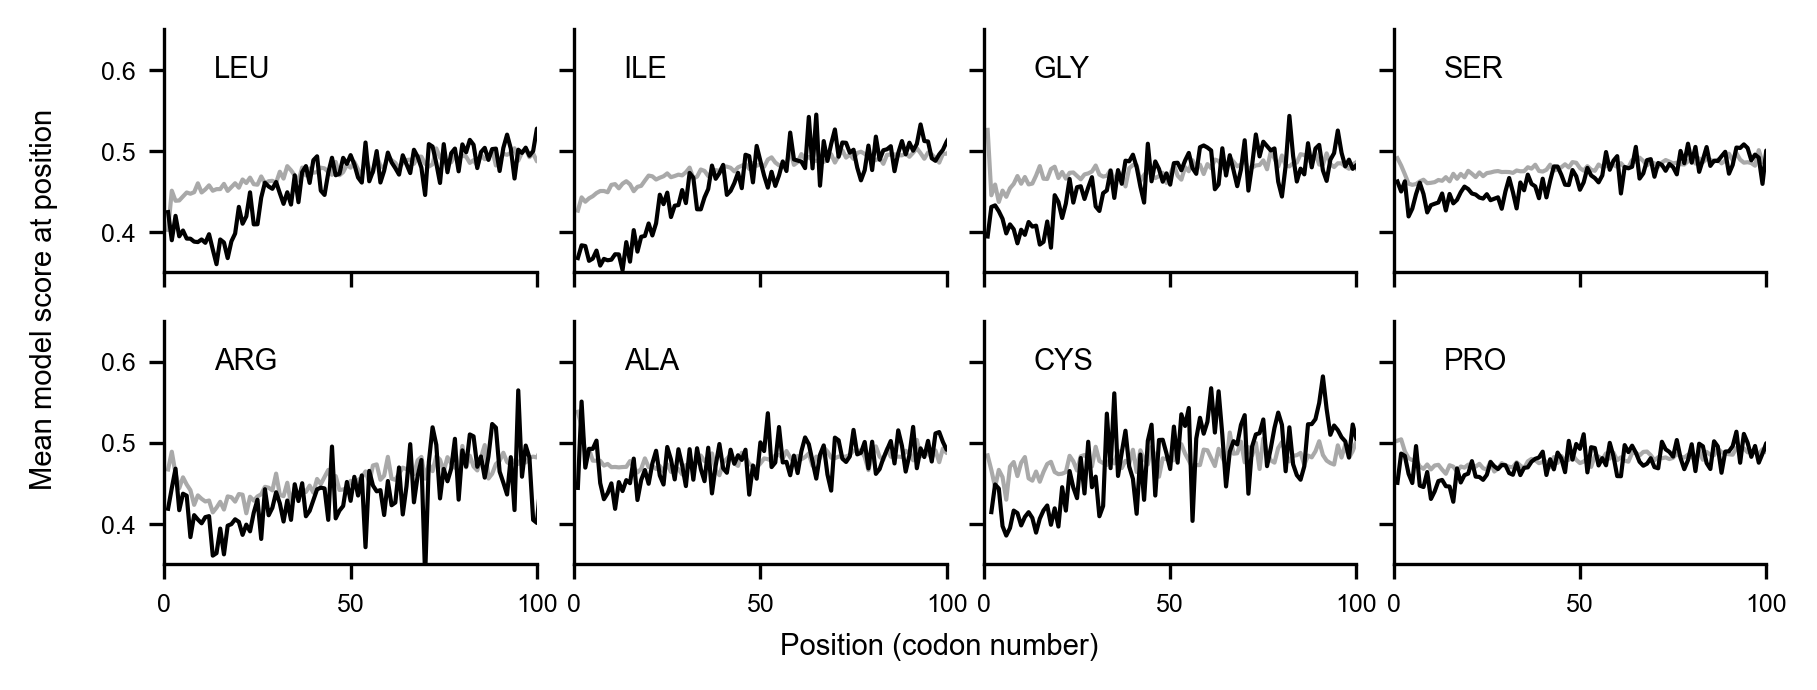

In [26]:
#Supplementary Figure 1
#I would like to compare signal/transit peptide starts vs none for each amino acid
fig, axs = plt.subplots(2,4, figsize=(17.5*cm,6*cm), sharex=True, sharey=True, constrained_layout=True) #previously 10x16
fig.subplots_adjust(wspace=0.1)
fig.supxlabel('Position (codon number)', y=-0.01, fontsize=7)
fig.supylabel('Mean model score at position', x=0.06, fontsize=7)
cond = results.gene.isin(protein_db[protein_db.type.isin(['Signal peptide', 'Transit peptide'])].gene.unique()) 
for aa, ax in zip(['LEU','ILE','GLY','SER','ARG','ALA','CYS','PRO'], axs.flatten()):
    bg = results.AA == aa
    x, pred, counts = mean_for_vals_at_pos(results.model_score[bg & (~cond)], results.position[bg & (~cond)], weights=results.weight[bg & (~cond)])
    ax.plot(x, pred, label='Genes without signal or transit peptide', linewidth=1, 
             color='darkgrey')
    x, pred, counts = mean_for_vals_at_pos(results.model_score[bg & (cond)], results.position[bg & (cond)], weights=results.weight[bg & (cond)])
    ax.plot(x, pred, label='Genes with signal or transit peptide', linewidth=1, 
             color='black')
    ax.set_ylim(0.35,0.65)
    ax.set_xlim(0,100)
    ax.legend(handles=[mlines.Line2D([], [], color='none', label=aa)], fontsize=7, loc='upper left', handlelength=0, frameon=False)
    ax.set_yticks([0.4,0.5, 0.6])
    ax.set_xticks([0,50, 100])
    ax.tick_params(labelsize=6)

    ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'supp_position_speed_by_peptide_all_AA.pdf', format='pdf', bbox_inches='tight')
plt.show()


all


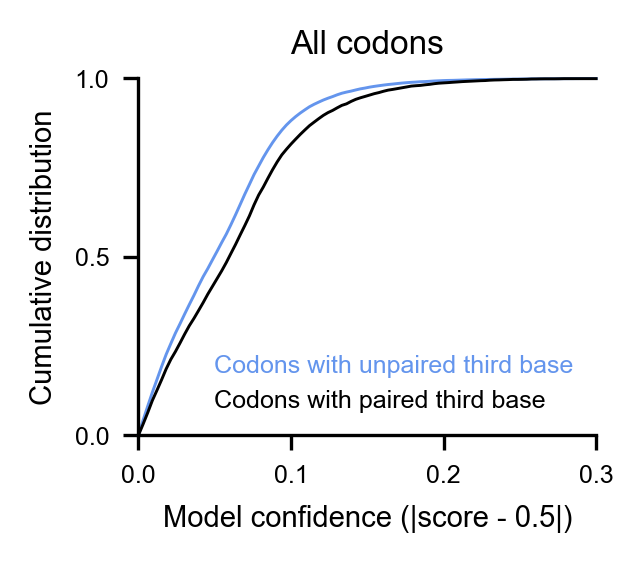

paired 17686 unpaired 58684
Welchs ttest pvalue 1.1080005860674396e-55

GCC
      AA    cf    tai        er fast_label change_to
GCC  ALA  12.6  0.488  1.432074       True       GCG


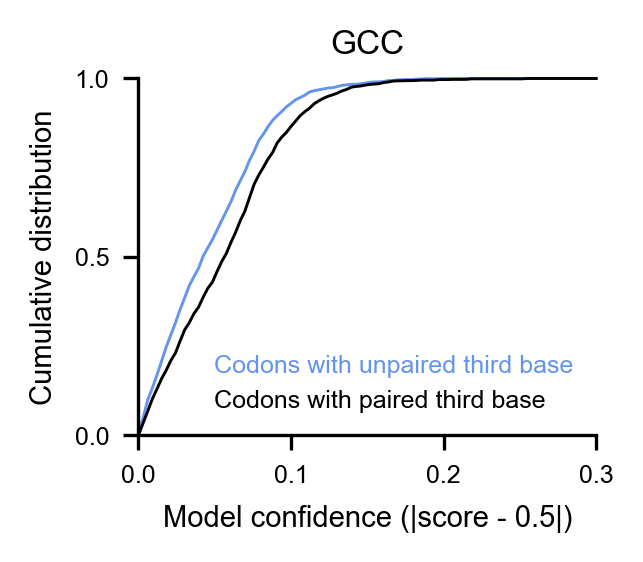

paired 3555 unpaired 2380
Welchs ttest pvalue 3.199673820956949e-05

TCC
      AA    cf    tai        er fast_label change_to
TCC  SER  14.2  0.488  1.413834       True       AGC


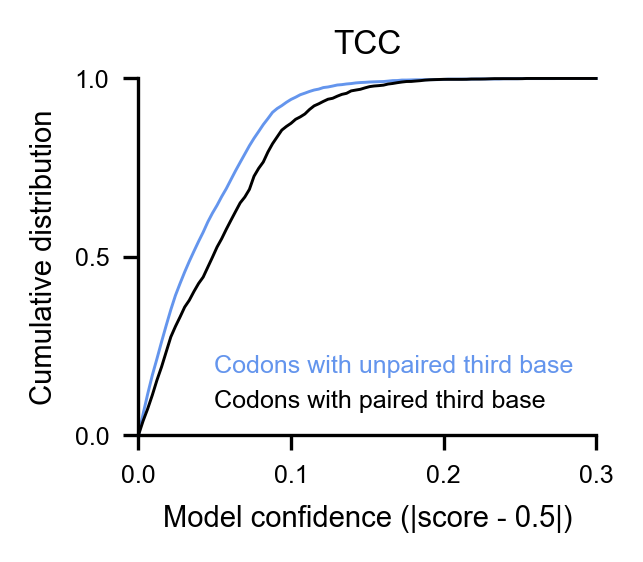

paired 2213 unpaired 4022
Welchs ttest pvalue 3.610210402671429e-11



In [27]:
#Unused Supplementary Figure
#At positions where DMS MaPseq indicates that the third nucleotide of the codon may be paired, 
#the model gives more extreme scores than for positions where DMS MaPseq indicates the nucleotide is unpaired 
#This can be observed even when comparing paired/unpaired for individual codons such as GCC, TCC 
#this implies that the difference in model confidence on paired/unpaired positions cannot be explained by differences
#in model confidence on different codons
cond_2_unpaired = (results.dms_2 > 0.04) #third position in codon
cond_2_paired = (~results.dms_2.isna()) & (results.dms_2 < 0.01) 

for c in ['all','GCC','TCC']:
    bg = True
    if c != 'all':
        bg = (results.codon == c) & bg


    print(c)
    if c != 'all':
        print(codon_info[codon_info.index == c])

    fig, ax = plt.subplots(figsize = (5*cm,4*cm))
    x,y = cumulative_dist(np.abs(results.model_score - 0.5)[cond_2_unpaired & bg], stop=0.3, weights=results.weight[cond_2_unpaired & bg])
    plt.plot(x,y, color='cornflowerblue', label='pos 2 unpaired (dms-mapseq)', clip_on=False, linewidth=0.7)

    x,y = cumulative_dist(np.abs(results.model_score - 0.5)[cond_2_paired & bg], stop=0.3, weights=results.weight[cond_2_paired & bg])
    plt.plot(x,y, color='black', label='pos 2 paired (dms-mapseq)', clip_on=False, linewidth=0.7)
    handles = [
        mlines.Line2D([], [], color='none', label='Codons with unpaired third base'),
        mlines.Line2D([], [], color='none', label='Codons with paired third base')
    ]

    plt.legend(handles=handles, labelcolor=['cornflowerblue', 'black'], fontsize=6, handlelength=0, frameon=False)
    plt.xlabel('Model confidence (|score - 0.5|)', fontsize=7)
    plt.ylabel('Cumulative distribution', fontsize=7)
    plt.xticks([0,0.1,0.2,0.3], fontsize=6)
    plt.yticks([0,0.5,1], fontsize=6)
    plt.ylim([0,1])
    plt.xlim([0,0.3])
    ax.spines[['right','top']].set_visible(False)
    plt.title('All codons' if c is 'all' else c, fontsize=8)
    plt.savefig(fig_dir + 'supp_paired_vs_unpaired_'+c+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    print('paired', np.sum(cond_2_paired & bg), 'unpaired', np.sum(cond_2_unpaired & bg))
    tstat, pval, df = smw.ttest_ind(np.abs(results.model_score - 0.5)[cond_2_unpaired & bg], 
                                    np.abs(results.model_score - 0.5)[cond_2_paired & bg],
                                    usevar='unequal', weights=(results.weight[cond_2_unpaired & bg],
                                                               results.weight[cond_2_paired & bg]))
    print('Welchs ttest pvalue', pval)
    print()


1611


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


all AA
only look at positions 0+
only use positions with at least 50 examples


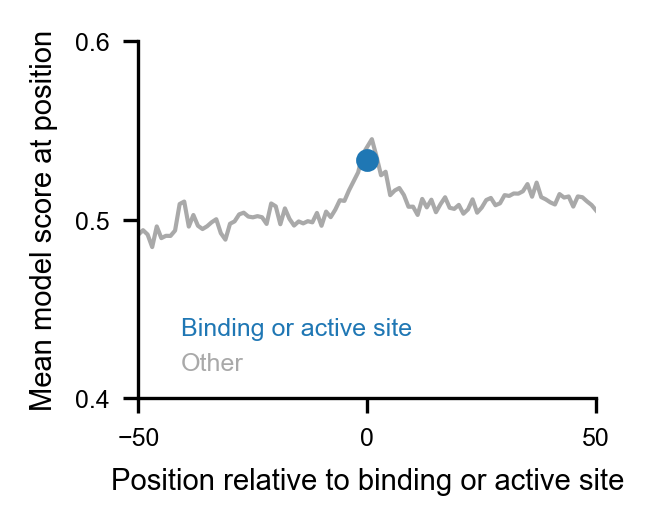

In [28]:
#Figure 3F
#Model predicts fast codons in binding and active sites
pdb = pd.concat([get_protein_type(protein_db, 'Active site'), get_protein_type(protein_db, 'Binding site')])
segments = np.array(pdb[['gene','start','end']])
segments[:,1] = segments[:,1] - 1 #adjust start to 0 index

positions = np.array(results[['gene', 'position']])
ds_bp_start_bas = bp_away_from(positions, segments, edge='start', direction='either') #nearest


f_colors = {'Other':'darkgrey', 'Binding or active site':'tab:blue'} 
max_dist = 50
start_cutoff = 0

aa = 'all AA'
edge = "start"
ds_bp = np.copy(ds_bp_start_bas)

ds_bp[ds_bp < -max_dist] = np.nan 
ds_bp[ds_bp > max_dist] = np.nan 
print(aa)
bg = True if aa == 'all AA' else results.AA == aa
bg = bg & (results.position > start_cutoff)
count_th = 30
if aa == 'all AA':
    count_th = 50
print(f"only look at positions {start_cutoff}+")
print(f'only use positions with at least {count_th} examples')
fig, ax = plt.subplots(figsize=(5*cm, 4*cm))
plt.xlabel(f'Position relative to binding or active site', fontsize=7)
plt.ylabel('Mean model score at position', fontsize=7)
for feature in ['Binding or active site', 'Other']:
    if feature == 'Other':
        cond = bg
        for f in f_colors.keys():
            if f != 'Other':
                cond = cond & (~positions_in_feature[f])
    else:
        cond = positions_in_feature[feature] & bg
    x, mean_score, counts = mean_for_vals_at_pos(results.model_score[cond], ds_bp[cond], weights=results.weight[cond])
    #show only first position for active/binding site
    if feature == 'Binding or active site':
        idx = x == 0
        x = x[idx]
        mean_score = mean_score[idx]
        counts = counts[idx]

    if feature=='Other':
        plt.plot(x[counts > count_th], mean_score[counts > count_th], color=f_colors[feature], label=feature.split(':')[-1], zorder=0, lw=1)
    else: 
        plt.scatter(x[counts > count_th],mean_score[counts > count_th], s=20, color=f_colors[feature], label=feature.split(':')[-1], zorder=10)
        
handles = [
    mlines.Line2D([],[], color='none', label='Binding or active site'),
    mlines.Line2D([],[], color='none', label='Other')
]        

plt.legend(handles=handles, labelcolor=[f_colors[c] for c in ['Binding or active site', 'Other']],
           handlelength=0, fontsize=6, frameon=False, loc='lower left')
plt.ylim(0.4,0.6)
plt.xlim(-50,50)
plt.yticks([0.4,0.5,0.6], fontsize=6)
plt.xticks([-50,0,50], fontsize=6)
ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'binding_or_active_site.pdf', format='pdf', bbox_inches='tight')
plt.show()
            

In [29]:
#are positions in binding and active sites predicted significantly faster than other positions? 
#compare to other positions in genes with binding or actiove sites
#effect sizes per amino acid
pdb = pd.concat([get_protein_type(protein_db, 'Active site'), get_protein_type(protein_db, 'Binding site')])
per_aa_db = {}
for aa in ['all AA','CYS','PRO','ARG','ALA','GLY', 'SER', 'ILE', 'LEU']:
    bg =  (results.gene.isin(pdb.gene)) 
    if aa == 'all AA':
        bg = bg
    else:
        bg = (results.AA == aa) & bg
    cond1 = positions_in_feature['Binding or active site']
    cond2 = ~positions_in_feature['Binding or active site']
    per_aa_db[aa] = {}
    s1 = results.model_score[bg&cond1]
    s2 =  results.model_score[bg&cond2]
    w1 =  results.weight[bg&cond1]
    w2 = results.weight[bg&cond2]
    wm1 = np.sum(s1*w1)/np.sum(w1)
    wm2 = np.sum(s2*w2)/np.sum(w2)
    per_aa_db[aa]['mean_weighted_score_critical'] = wm1
    per_aa_db[aa]['mean_weighted_score_noncritical'] = wm2
    tstat, pval, df = smw.ttest_ind( s1, s2, usevar='unequal', weights=(w1,w2))
    per_aa_db[aa]['weighted_welchs_ttest_tstat'] = tstat
    per_aa_db[aa]['weighted_welchs_ttest_p-value'] = pval
    per_aa_db[aa]['weighted_welchs_ttest_df'] = df
    pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
    per_aa_db[aa]['effect_size'] = np.abs(wm1 - wm2)/pool_stdev
    
per_aa_db = pd.DataFrame(per_aa_db).T
per_aa_db

,mean_weighted_score_critical,mean_weighted_score_noncritical,weighted_welchs_ttest_tstat,weighted_welchs_ttest_p-value,weighted_welchs_ttest_df,effect_size
all AA,0.556681,0.501345,33.048757,4.474781e-208,3415.943675,0.730675
CYS,0.520007,0.499508,6.606762,7.765876e-11,701.923304,0.293557
PRO,0.525811,0.499900,7.250843,8.024065e-12,207.881170,0.503190
ARG,0.569409,0.501816,8.552662,1.394411e-13,100.603437,0.819795
ALA,0.521386,0.505117,2.291861,2.361704e-02,122.774066,0.245505
GLY,0.576788,0.498733,26.332654,9.904204e-128,1638.428874,0.764004
SER,0.569958,0.498374,21.345316,4.388592e-69,421.808767,1.164272
ILE,0.551764,0.503688,7.323672,8.804876e-12,172.714363,0.653746
LEU,0.536936,0.505393,6.500750,6.286209e-10,199.214647,0.465473


In [30]:
#are positions in binding and active sites predicted significantly faster than other positions in structured regions? 
#effect sizes per amino acid
pdb = pd.concat([get_protein_type(protein_db, 'Active site'), get_protein_type(protein_db, 'Binding site')])
print('Background is structured region, pLDDT > 90')
per_aa_db = {}
for aa in ['all AA','CYS','PRO','ARG','ALA','GLY', 'SER', 'ILE', 'LEU']:
    bg =  (results.gene.isin(pdb.gene)) & (results.pLDDT > 90)
    if aa == 'all AA':
        bg = bg
    else:
        bg = (results.AA == aa) & bg
    cond1 = positions_in_feature['Binding or active site']
    cond2 = ~positions_in_feature['Binding or active site']
    per_aa_db[aa] = {}
    s1 = results.model_score[bg&cond1]
    s2 =  results.model_score[bg&cond2]
    w1 =  results.weight[bg&cond1]
    w2 = results.weight[bg&cond2]
    wm1 = np.sum(s1*w1)/np.sum(w1)
    wm2 = np.sum(s2*w2)/np.sum(w2)
    per_aa_db[aa]['mean_weighted_score_critical'] = wm1
    per_aa_db[aa]['mean_weighted_score_noncritical'] = wm2
    tstat, pval, df = smw.ttest_ind( s1, s2, usevar='unequal', weights=(w1,w2))
    per_aa_db[aa]['weighted_welchs_ttest_tstat'] = tstat
    per_aa_db[aa]['weighted_welchs_ttest_p-value'] = pval
    per_aa_db[aa]['weighted_welchs_ttest_df'] = df
    pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
    per_aa_db[aa]['effect_size'] = np.abs(wm1 - wm2)/pool_stdev
    
per_aa_db = pd.DataFrame(per_aa_db).T
per_aa_db

Background is structured region, pLDDT > 90


,mean_weighted_score_critical,mean_weighted_score_noncritical,weighted_welchs_ttest_tstat,weighted_welchs_ttest_p-value,weighted_welchs_ttest_df,effect_size
all AA,0.545915,0.509407,17.769926,8.888626e-66,2030.972695,0.475345
CYS,0.517554,0.507440,2.836487,4.736191e-03,528.705976,0.146105
PRO,0.521256,0.499897,4.151962,6.691859e-05,105.797298,0.412366
ARG,0.573262,0.514548,6.381254,1.372755e-08,73.906416,0.721598
ALA,0.514385,0.503001,1.318366,1.914895e-01,73.238570,0.166035
GLY,0.560078,0.506792,13.102517,9.597799e-36,818.165321,0.504450
SER,0.566143,0.510463,13.202860,1.105123e-30,255.117620,0.863108
ILE,0.552914,0.513939,4.962282,2.143488e-06,129.797476,0.538788
LEU,0.538671,0.514983,3.972833,1.125506e-04,141.904844,0.365369


low_th 50 high th 90


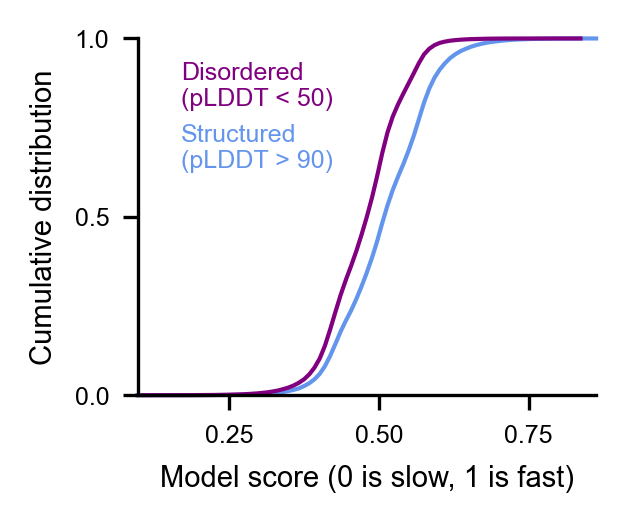

In [31]:
#Figure 3E
#Model predicts slower codons in flexible and disordered positions
m = 'model_score'
stop=max(results[m])
start = min(results[m])

low_th = 50
high_th = 90
print('low_th', low_th, 'high th', high_th)
cond1 = results.pLDDT < low_th
cond2 = results.pLDDT > high_th

stop=max(results[cond1 | cond2][m])
start=min(results[cond1 | cond2][m])

fig, ax = plt.subplots(figsize=(5*cm,4*cm))

x,y = cumulative_dist(results[cond1][m], start=0, stop=stop, clip=True, weights=results.weight[cond1])
plt.plot(x,y, label=f'Unstructured\n(pLDDT < {low_th})', color='purple', clip_on=False, zorder=-10, lw=1)
x,y = cumulative_dist(results[cond2][m], start=0, stop=stop, clip=True, weights=results.weight[cond2])
plt.plot(x,y, label=f'Structured\n(pLDDT > {high_th})', color='cornflowerblue', clip_on=False, zorder=-20, lw=1)
plt.xlabel('Model score (0 is slow, 1 is fast)', fontsize=7)
plt.ylabel('Cumulative distribution', fontsize=7)
plt.ylim((0,1))
plt.yticks([0,0.5,1], fontsize=6)
plt.xlim((start,stop))
plt.xticks([0.25,0.5,0.75], fontsize=6)
handles = [
    mlines.Line2D([],[], color='none', label= f'Disordered\n(pLDDT < {low_th})'),
    mlines.Line2D([],[], color='none', label=f'Structured\n(pLDDT > {high_th})'),
]
plt.legend(handles=handles, labelcolor=['purple', 'cornflowerblue'], frameon=False, fontsize=6, handlelength=0)
ax.spines[['top','right']].set_visible(False)
plt.savefig(fig_dir+'pLDDT_compare.pdf', format='pdf', bbox_inches='tight')
plt.show()

low_th 50 high th 90


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


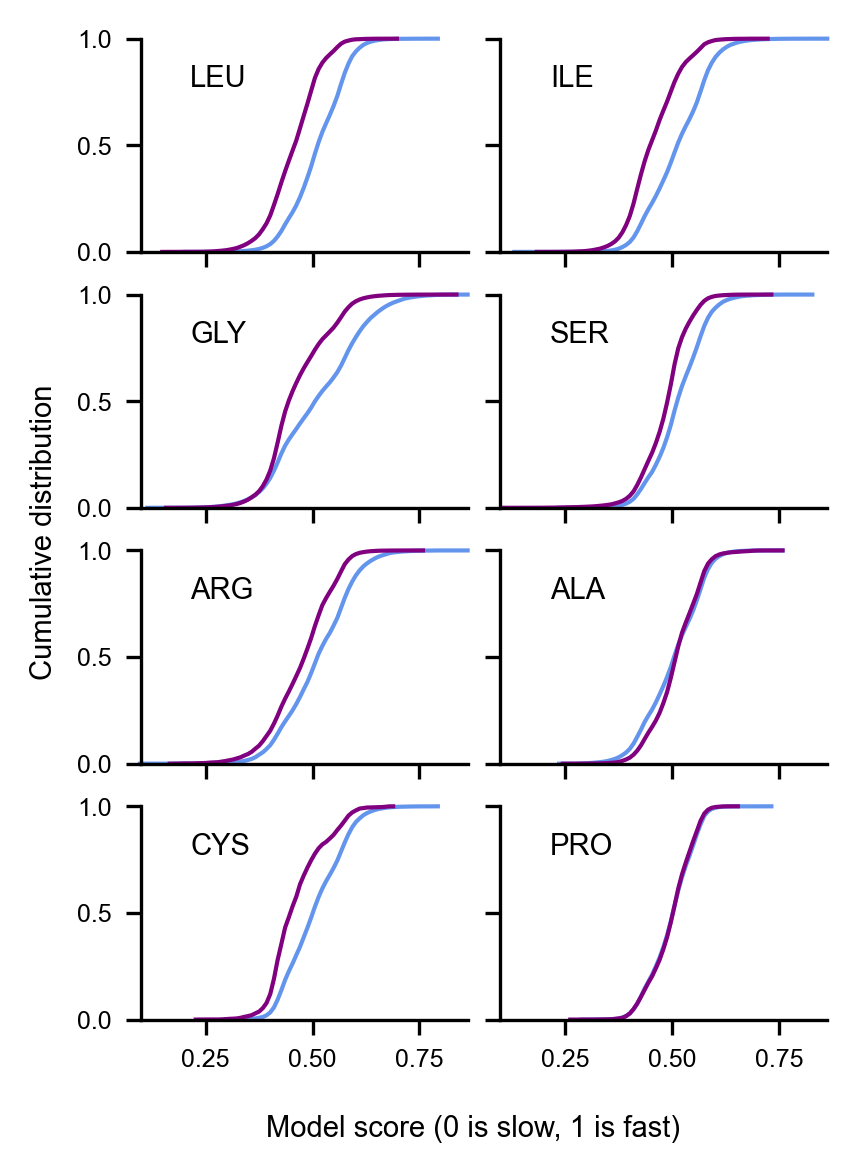

In [32]:
#Supplementary Figure 2
#Repeat for each amino acid
m = 'model_score'
stop=max(results[m])
start = min(results[m])

low_th = 50
high_th = 90
print('low_th', low_th, 'high th', high_th)
cond1 = results.pLDDT < low_th
cond2 = results.pLDDT > high_th

stop=max(results[cond1 | cond2][m])
start=min(results[cond1 | cond2][m])


fig, axs = plt.subplots(4,2, figsize=(7.5*cm,11*cm), sharex=True, sharey=True, constrained_layout=True) #previously - 10 by 16
fig.subplots_adjust(wspace=0.1)
fig.supxlabel('Model score (0 is slow, 1 is fast)', y=0.03, fontsize=7)
fig.supylabel('Cumulative distribution', x=0.0, fontsize=7)
for aa, ax in zip(['LEU','ILE','GLY','SER','ARG','ALA','CYS','PRO'], axs.flatten()):
    bg = results.AA == aa
    x,y = cumulative_dist(results[bg&cond1][m], start=0, stop=stop, clip=True, weights=results.weight[cond1&bg])
    ax.plot(x,y, label=f'Disordered\n(pLDDT < {low_th})', color='purple', clip_on=False, zorder=-10, lw=1)
    x,y = cumulative_dist(results[bg&cond2][m], start=0, stop=stop, clip=True, weights=results.weight[cond2&bg])
    ax.plot(x,y, label=f'Structured\n(pLDDT > {high_th})', color='cornflowerblue', clip_on=False, zorder=-20, lw=1)
    ax.set_ylim(0,1)
    ax.set_xlim(start,stop)
    ax.legend(handles=[mlines.Line2D([], [], color='none', label=aa)], fontsize=7, loc='upper left', handlelength=0, frameon=False)
    ax.set_yticks([0,0.5,1])
    ax.set_xticks([0.25,0.5,0.75])
    ax.tick_params(labelsize=6)

    ax.spines[['right','top']].set_visible(False)
plt.savefig(fig_dir + 'supp_pLDDT_compare_all_AA.pdf', format='pdf', bbox_inches='tight')
plt.show()

/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if __name__ == '__main__':


low_th 50 high th 90


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


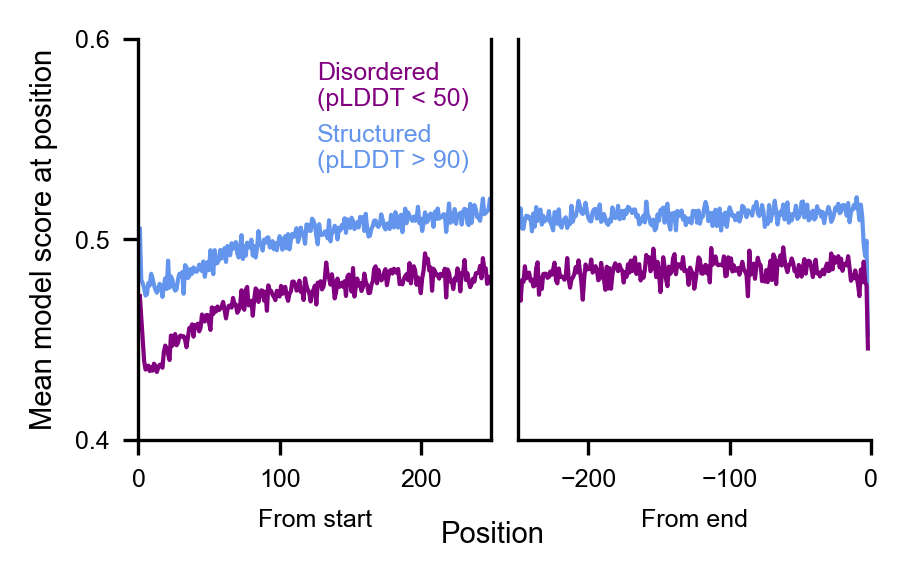

In [33]:
#Supplementary Figure 2
#does the difference depend on position?
#structured vs. unstructured across entire position?
#but the also want to show it at the back?
#fig, ax = plt.subplots(figsize=(5*cm,4*cm))

#Supplementary Figure

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8*cm, 4.5*cm), constrained_layout=True, sharex=False)
fig.subplots_adjust(wspace=0.075)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax1.set_ylabel('Mean model score at position', fontsize=7)


low_th = 50
high_th = 90
print('low_th', low_th, 'high th', high_th)
cond1 = results.pLDDT < low_th
cond2 = results.pLDDT > high_th
x, pred, counts = mean_for_vals_at_pos(results.model_score[cond2], results.position[cond2], weights=results.weight[cond2])
ax1.plot(x, pred, linewidth=1, color='cornflowerblue')
x, pred, counts = mean_for_vals_at_pos(results.model_score[cond1], results.position[cond1], weights=results.weight[cond1])
ax1.plot(x, pred, linewidth=1, color='purple')

ax1.set_xlim(0,250)
ax1.set_ylim(0.4,0.6)
ax1.tick_params(labelsize=6)
ax1.set_yticks([0.4,0.5,0.6])
ax1.set_xticks([0, 100, 200])
ax1.set_xlabel(f'From start', fontsize=6)


from_end = results.position - results.gene.map(db_genes.length) 

x, pred, counts = mean_for_vals_at_pos(results.model_score[cond2], from_end[cond2], weights=results.weight[cond2])
ax2.plot(x, pred, linewidth=1, color='cornflowerblue')
x, pred, counts = mean_for_vals_at_pos(results.model_score[cond1], from_end[cond1], weights=results.weight[cond1])
ax2.plot(x, pred, linewidth=1, color='purple')
ax2.set_xlim(-250,0)
#ax2.set_ylim(0.4,0.6)
ax2.tick_params(labelsize=6)
#ax2.set_yticks([0.4,0.5,0.6])
ax2.set_xticks([-200, -100, 0])
ax2.set_xlabel(f'From end', fontsize=6)


fig.supxlabel('Position', y=-0.08, fontsize=7)    


handles = [
    mlines.Line2D([],[], color='none', label= f'Disordered\n(pLDDT < {low_th})'),
    mlines.Line2D([],[], color='none', label=f'Structured\n(pLDDT > {high_th})'),
]
ax1.legend(handles=handles, labelcolor=['purple', 'cornflowerblue'], frameon=False, fontsize=6, handlelength=0)

ax1.spines[['top']].set_visible(False)
ax2.spines[['top','right']].set_visible(False)
plt.savefig(fig_dir + 'supp_score_by_structure_and_position.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [34]:
#per amino acid significance and effect size
per_aa_db = {}
for aa in ['all AA','CYS','PRO','ARG','ALA','GLY', 'SER', 'ILE', 'LEU']:
    if aa == 'all AA':
        bg = True
    else:
        bg = results.AA == aa
    cond1 = results.pLDDT > 90
    cond2 = results.pLDDT < 50
    per_aa_db[aa] = {}
    s1 = results.model_score[bg&cond1]
    s2 =  results.model_score[bg&cond2]
    w1 =  results.weight[bg&cond1]
    w2 = results.weight[bg&cond2]
    wm1 = np.sum(s1*w1)/np.sum(w1)
    wm2 = np.sum(s2*w2)/np.sum(w2)
    per_aa_db[aa]['mean_weighted_score_structured'] = wm1
    per_aa_db[aa]['mean_weighted_score_disordered'] = wm2
    tstat, pval, df = smw.ttest_ind( s1, s2, usevar='unequal', weights=(w1,w2))
    per_aa_db[aa]['weighted_welchs_ttest_tstat'] = tstat
    per_aa_db[aa]['weighted_welchs_ttest_p-value'] = pval
    per_aa_db[aa]['weighted_welchs_ttest_df'] = df
    pool_stdev = weighted_pooled_stdev(s1, w1, s2, w2)
    per_aa_db[aa]['effect_size'] = np.abs(wm1 - wm2)/pool_stdev
    
per_aa_db = pd.DataFrame(per_aa_db).T
per_aa_db

,mean_weighted_score_structured,mean_weighted_score_disordered,weighted_welchs_ttest_tstat,weighted_welchs_ttest_p-value,weighted_welchs_ttest_df,effect_size
all AA,0.508942,0.475820,133.350054,0.000000e+00,249020.464561,0.476661
CYS,0.504709,0.461446,27.360573,7.300253e-145,2568.964121,0.649046
PRO,0.497909,0.497246,1.280623,2.003343e-01,36636.825005,0.013146
ARG,0.510636,0.474144,28.176978,1.567034e-169,12806.802580,0.474321
ALA,0.500557,0.507522,-8.063441,7.926100e-16,16383.539267,0.110304
GLY,0.509959,0.460382,67.150663,0.000000e+00,52462.193857,0.533821
SER,0.512875,0.483286,63.298371,0.000000e+00,55921.276906,0.521350
ILE,0.511870,0.454919,92.995249,0.000000e+00,24889.344318,0.839191
LEU,0.511771,0.454920,83.609871,0.000000e+00,15551.446625,0.917332


In [35]:
#Unused Supplementary Table
structure_per_aa_db = per_aa_db
keep_cols = {'mean_weighted_score_structured':"Mean score inside structured regions",
            'mean_weighted_score_disordered':"Mean score inside disordered regions",
             'weighted_welchs_ttest_tstat':'T-statistic',
             'weighted_welchs_ttest_p-value':"P-value", 
             'effect_size':'Effect size'}
structure_per_aa_db = structure_per_aa_db.rename(columns=keep_cols)[list(keep_cols.values())]
#peptide_per_aa_db.round(decimals=2)
structure_per_aa_db

,Mean score inside structured regions,Mean score inside disordered regions,T-statistic,P-value,Effect size
all AA,0.508942,0.475820,133.350054,0.000000e+00,0.476661
CYS,0.504709,0.461446,27.360573,7.300253e-145,0.649046
PRO,0.497909,0.497246,1.280623,2.003343e-01,0.013146
ARG,0.510636,0.474144,28.176978,1.567034e-169,0.474321
ALA,0.500557,0.507522,-8.063441,7.926100e-16,0.110304
GLY,0.509959,0.460382,67.150663,0.000000e+00,0.533821
SER,0.512875,0.483286,63.298371,0.000000e+00,0.521350
ILE,0.511870,0.454919,92.995249,0.000000e+00,0.839191
LEU,0.511771,0.454920,83.609871,0.000000e+00,0.917332


4868
4868


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


all AA
only look at positions 0+
only use positions with at least 50 examples
pfam domain 2131.7524752475247 mean count per position
other 1514.88 mean count per position
all AA
only look at positions 0+
only use positions with at least 50 examples


/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


pfam domain 2087.37 mean count per position
other 1405.3564356435643 mean count per position


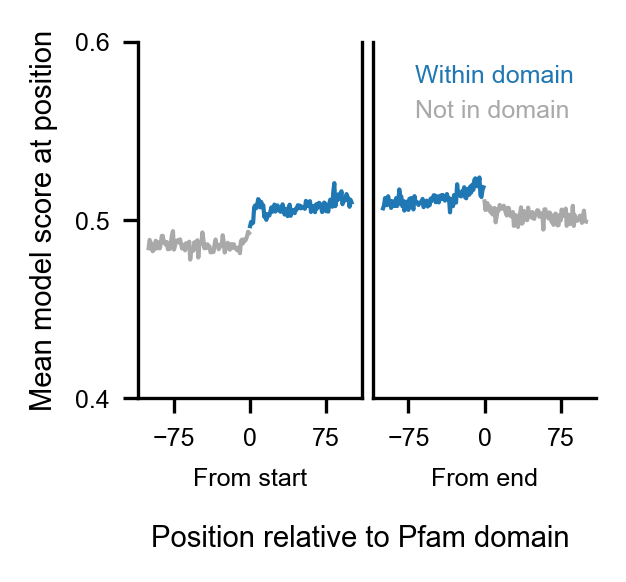

In [36]:
#Figure 3D
#Model predicts fast codons in pfam domains - no slowdown downstream of domain
segments = np.array(pfam.dropna()[['orf','start','end']])
segments[:,1] = segments[:,1] - 1 #adjust start to 0 index

positions = np.array(results[['gene', 'position']])
ds_bp_pfam_start = bp_away_from(positions, segments, edge='start', direction='either') #nearest
ds_bp_pfam_end = bp_away_from(positions, segments, edge='end', direction='either') #nearest


f_colors = {'pfam domain':'tab:blue', 'other':'darkgray'} 
f_to_name = {x:x for x in f_colors}
f_to_name['Region:Disordered']='disordered region'
          
max_dist = 100
start_cutoff = 0
    
aa = 'all AA'
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5*cm, 4*cm), constrained_layout=True, sharex=True)
fig.subplots_adjust(wspace=0.05)
ax2.tick_params(axis='y', left=False, labelleft=False)
ax1.set_ylabel('Mean model score at position', fontsize=7)

for edge in ["start","end"]:
    if edge == "start":
        ax = ax1
        ds_bp = np.copy(ds_bp_pfam_start)
    else:
        ax = ax2
        ds_bp = np.copy(ds_bp_pfam_end)
    ds_bp[ds_bp < -max_dist] = np.nan 
    ds_bp[ds_bp > max_dist] = np.nan 
    print(aa)
    bg = True 


    bg = bg if aa == 'all AA' else bg & (results.AA == aa)

    bg = bg & (results.position > start_cutoff)
    
    count_th = 20
    if aa == 'all AA':
        count_th = 50
    print(f"only look at positions {start_cutoff}+")
    print(f'only use positions with at least {count_th} examples')

    ax.set_xlabel(f'From {edge}', fontsize=6)
    for feature in f_colors.keys():
        if feature == 'other':
            cond = bg
            for f in f_colors.keys():
                if feature != 'other':
                    cond = cond & (~positions_in_feature[feature])
        elif feature != 'pfam domain':
            cond =  bg & positions_in_feature[feature] & (~positions_in_feature['pfam domain'])
        else:
            cond = bg & positions_in_feature[feature]
        x, mean_score, counts = mean_for_vals_at_pos(results.model_score[cond], ds_bp[cond], weights=results.weight[cond])
        
        #after start/before end, plot only domain, before start/after end, plot only non-domain positions
        if (edge == 'end') != (feature == 'pfam domain'): 
            idx = (counts > count_th) & (x >= 0)
            ax.plot(x[idx], mean_score[idx], color=f_colors[feature], label=f_to_name[feature], lw=1)
        else: 
            idx = (counts > count_th) & (x < 0)
            ax.plot(x[idx], mean_score[idx], color=f_colors[feature], lw=1)

        print(feature, np.nanmean(counts[idx]), 'mean count per position')

    ax.set_ylim(0.4,0.6)
    ax.set_yticks([0.4,0.5,0.6])
    ax.set_xticks([-75,0,75])
    ax.tick_params(labelsize=6)
    if m == 'mean label (weighted)':
        ax.set_ylim(0,1)
    if m == 'pLDDT (weighted)':
        ax.set_ylim(0,100)
        ax.set_yticks([25,50,75,80,90])

handles = [
    mlines.Line2D([],[],color='none',label='Within domain'),
    mlines.Line2D([],[],color='none',label='Not in domain'),
]
ax2.legend(handles=handles, labelcolor=['tab:blue','darkgray'], fontsize=6, frameon=False)
ax1.spines[['top']].set_visible(False)
ax2.spines[['top','right']].set_visible(False)

fig.supxlabel('Position relative to Pfam domain', y=-0.2, fontsize=7)    
plt.savefig(fig_dir + 'pfam_domain.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [37]:
#pruning go terms for GO analysis 3-17-25-pool_comp
#background set = genes with fast-to-slow or slow-to-fast variants in pooled competition experiment
#selected set = genes with significant advantageous or deleterious fast-to-slow or slow-to-fast variants (in pooled competition)
go_db = go_analysis['3-17-25-pool_comp'] 
#fold enrichment of at least 1.5
pool_comp_terms = go_db[(go_db.fdr < 0.1) & (go_db.fold_enrichment > 1.5)] 
#remove a few additional overlapping terms:
#'RNA helicase activity' and 'ATP-dependent activity, acting on RNA' mostly overlap
#'ATP-dependent activity' and 'ATP hydrolysis activity' mostly overlap
#'nucleoid' and 'mitochondrial nucleoid' entirely overlap
pool_comp_terms_to_prune = ['ATP-dependent activity, acting on RNA', 'ATP hydrolysis activity', 
                        'nucleoid']
pool_comp_pruned_terms = pool_comp_terms[~pool_comp_terms.index.isin(pool_comp_terms_to_prune)]
pool_comp_pruned_terms

,number_in_reference,number_in_list,fold_enrichment,fdr,expected,pValue,plus_minus,level,id,label,genes,reference_genes,annotation_set,group
ATP-dependent activity,124,37,1.93193,0.0208164,19.1518,1.65868e-05,+,2,GO:0140657,ATP-dependent activity,"[YDR188W, YHR169W, YPR088C, YOR326W, YBR202W, ...","[YPR180W, YNR038W, YDR188W, YMR301C, YOR326W, ...",molecular_function,m24
RNA helicase activity,28,12,2.77482,0.0726607,4.32461,0.000405279,+,1,GO:0003724,RNA helicase activity,"[YJL050W, YDL031W, YFL002C, YHR169W, YBR142W, ...","[YDR021W, YNR038W, YHR169W, YKR086W, YGL120C, ...",molecular_function,m33
mitochondrion,207,50,1.56391,0.063304,31.9712,0.000271691,+,2,GO:0005739,mitochondrion,"[YDL207W, YKL033W, YCL017C, YHR070W, YNL088W, ...","[YML091C, YMR301C, YGR029W, YER125W, YKL033W, ...",cellular_component,c2
mitochondrial nucleoid,7,6,5.54964,0.053832,1.08115,7.70129e-05,+,1,GO:0042645,mitochondrial nucleoid,"[YFL036W, YER095W, YJR045C, YLR259C, YLR355C, ...","[YFL036W, YER095W, YJR045C, YLR355C, YLR259C, ...",cellular_component,c16


Keep only most significant guide
all tested: 6886 positions in 1238 genes
ATP-dependent activity tested: 1151 positions in 124 genes
RNA helicase activity tested: 297 positions in 28 genes
mitochondrion tested: 1643 positions in 207 genes
mitochondrial nucleoid tested: 122 positions in 7 genes


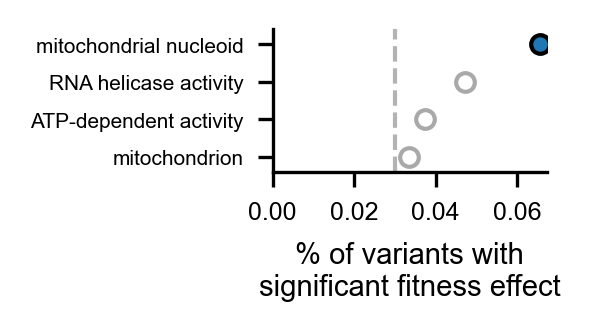

,num_genes,num_codons,num_sig,percent_significant,zscore_percent_significant,pval_percent_significant,GO_term,annotation_set,log_pval
mitochondrion,207.0,1643,55.0,0.033475,0.720669,0.471113,mitochondrion,NaN,0.326875
ATP-dependent activity,124.0,1151,43.0,0.037359,1.320099,0.186802,ATP-dependent activity,NaN,0.728619
RNA helicase activity,28.0,297,14.0,0.047138,1.668647,0.095187,RNA helicase activity,NaN,1.021421
mitochondrial nucleoid,7.0,122,8.0,0.065574,2.254733,0.024150,mitochondrial nucleoid,cellular_component,1.617081


In [38]:
#Figure 4F
#'Positions in mitochondrial nucleoid genes\nare sensitive to synonymous mutations'
#consider the GO terms above - are slow-to-fast / fast-to-slow mutations in these genes more likely to
#have a significant effect on fitness?
#(variable number of positions tested per gene - simply looking at which genes are enriched among significant variants is not enough)
def get_experiment_stats(cond, db):
    if np.sum(cond) == 0:
        return {}
    sig = db['comp_padj'] < 0.05
    g_ = db.gene
    stats = {}
    stats['num_genes'] = len(np.unique(g_[cond]))
    stats['num_codons'] = np.sum(cond)
    stats['num_sig'] = np.sum(sig[cond])
    stats['percent_significant'] = np.sum(sig[cond])/np.sum(cond)
    stats['zscore_percent_significant'] = zscore(np.sum(cond), np.sum(sig[cond]), len(cond), np.sum(sig))
    stats['pval_percent_significant'] = scipy.stats.norm.sf(np.abs(zscore(np.sum(cond), np.sum(sig[cond]), len(cond), np.sum(sig))))*2
    return stats


    
pool_comp_go_term_stats = {}

print('Keep only most significant guide')
bg = (comp.variant == 'v') #slow-to-fast and fast-to-slow variants
db = comp[bg].sort_values(by='comp_padj').drop_duplicates(subset='target', keep='first') 

for term in ['all'] + list(pool_comp_pruned_terms.index):
    if term != 'all':
        cond = np.in1d(db.gene, pool_comp_pruned_terms.reference_genes[term])
    else:
        cond = np.ones(len(db.gene)).astype(bool)
    print(term, 'tested:', np.sum(cond), 'positions in', len(db[cond].gene.unique()), 'genes')
    pool_comp_go_term_stats[term] = get_experiment_stats(cond, db)
    

pool_comp_go_term_stats = pd.DataFrame(pool_comp_go_term_stats).T
pool_comp_go_term_stats.sort_values(by='percent_significant', ascending=False)



df = pool_comp_go_term_stats.sort_values(by='percent_significant').drop('all')
df['GO_term'] = df.index
df['annotation_set'] = df.GO_term.map(pruned_terms.annotation_set)
df['log_pval'] = -np.log10(df['pval_percent_significant'])

y = 'GO_term'
x = 'percent_significant'
z = 'pval_percent_significant'
w = 'num_codons'


df[x] = df[x].astype(float)
df[z] = df[z].astype(float)
df[w] = df[w].astype(int)

fig, ax = plt.subplots(figsize=(3*cm, 1.6*cm))
y_positions = np.array(range(len(df)))

#baseline comparsion - rate of significant hits across slow-to-fast / fast-to-slow hits in experiment
baseline = pool_comp_go_term_stats['percent_significant']['all']
ax.axvline(baseline, color='dimgrey', alpha=0.5, lw=1,
                       linestyle='dashed') #, label='all genes')


scatter = plt.scatter(
    df[x][df[z] <= 0.05], y_positions[df[z] <= 0.05], s=20, 
    c = 'tab:blue',
    edgecolor = 'black', label='p < 0.05'
)

scatter = plt.scatter(
    df[x][df[z] > 0.05], y_positions[df[z] > 0.05], s=20, 
    c = 'white',
    edgecolor = 'darkgrey'
)

ax.set_yticks(y_positions)
ax.set_yticklabels(df[y], fontsize=5)
ax.set_xlabel('% of variants with\nsignificant fitness effect', fontsize=7)
#plt.xlim(0,0.07)
plt.ylim(min(y_positions)-0.4, max(y_positions)+0.4)
plt.xticks([0,0.02,0.04,0.06], fontsize=6)
ax.spines[['top', 'right']].set_visible(False)

plt.savefig(fig_dir + 'experimental_GO_percent_variants.pdf', format='pdf', bbox_inches='tight')
plt.show()
df

padj is adjusted p-value that |l2fc| > 0.58
Keep only most significant guide if there are multiple
num  slow-to-fast deleterious 66
num  slow-to-fast advantageous 27
num  slow-to-fast no-effect 2975
num  fast-to-slow deleterious 72
num  fast-to-slow advantageous 42
num  fast-to-slow no-effect 3704
total slow-to-fast or fast-to-slow 6886
deleterious slow-to-fast or fast-to-slow 138
advantageous slow-to-fast or fast-to-slow 69
% significant 0.030060993319779263


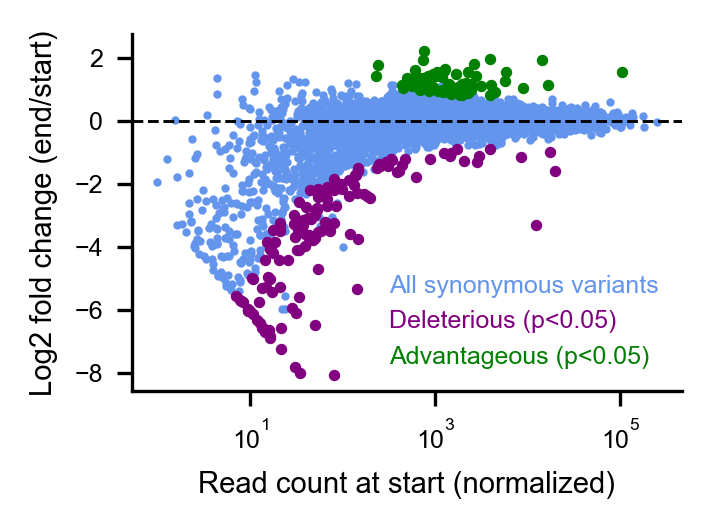

In [40]:
#Figure 4D
#Change in synonymous variants across competition
#(MA plot for pooled competirtion)
print('padj is adjusted p-value that |l2fc| > 0.58')

PADJ_TH = 0.05 
L2FC_TH = 0
padj_m = 'comp_padj'
l2fc_m = 'comp_l2fc'
base_m = 'comp_baseMean'

fig, ax = plt.subplots(figsize=(6*cm,4*cm))

print('Keep only most significant guide if there are multiple')
db = comp[(comp.variant == 'v')].sort_values(by='comp_padj').drop_duplicates(subset=['gene', 'w_codon_num'])
           #only slow-to-fast variants and fast-to-slow variants

plt.scatter(db[base_m], db[l2fc_m], s=1, alpha=1, color='cornflowerblue', label='all synonymous variants')


dele = (db[padj_m] < PADJ_TH) & (db[l2fc_m] < - L2FC_TH)
adv = (db[padj_m] < PADJ_TH) & (db[l2fc_m] > L2FC_TH)
for label in [0,1]:
    label_name = 'fast-to-slow' if label else 'slow-to-fast'
    print('num ', label_name, 'deleterious', np.sum(dele & (db.label == label)))
    print('num ', label_name, 'advantageous', np.sum(adv & (db.label == label)))
    print('num ', label_name, 'no-effect', np.sum((~(adv | dele)) & (db.label == label)))

print('total slow-to-fast or fast-to-slow', len(db))
conditions =  (db[padj_m] < PADJ_TH) & (db[l2fc_m] < - L2FC_TH)
print("deleterious slow-to-fast or fast-to-slow", np.sum(conditions))
plt.scatter(db[conditions][base_m], db[conditions][l2fc_m], s=3, color='purple', label=f"deleterious (p<{PADJ_TH})")
conditions = (db[padj_m] < PADJ_TH) & (db[l2fc_m] > L2FC_TH)
print("advantageous slow-to-fast or fast-to-slow", np.sum(conditions))
plt.scatter(db[conditions][base_m], db[conditions][l2fc_m], s=3, color='green', label=f"advantageous (p<{PADJ_TH})")
print("% significant", np.sum(db[padj_m] < PADJ_TH)/len(db))

plt.axhline(y=0, color='black', lw=0.7, ls='dashed')

plt.xscale('log')
plt.xlabel('Read count at start (normalized)', fontsize=7)
plt.ylabel('Log2 fold change (end/start)', fontsize=7)

handles = [
    mlines.Line2D([],[],color='none', label='All synonymous variants'),
    mlines.Line2D([],[],color='none', label='Deleterious (p<0.05)'),
    mlines.Line2D([],[],color='none', label='Advantageous (p<0.05)'),
    
]


plt.legend(handles=handles, labelcolor=['cornflowerblue','purple','green'], frameon=False, fontsize=6, framealpha=0.8, loc='lower right', handlelength=0)
ax.spines[['top','right']].set_visible(False)
plt.xticks([10,1000,100000], fontsize=6)
plt.yticks([-8,-6,-4,-2,0,2], fontsize=6)
plt.savefig(fig_dir+'competition_adv_del.pdf', format='pdf', bbox_inches='tight')
plt.show()

Controls for pooled competition
padj is adjusted p-value that |l2fc| > 0.58
Keep only most significant variant
random variants 42
deleterious random 0 advantageous 1
HO locus deletion variants 28
deleterious HO locus 0 advantageous 0
essential deletions 18
deleterious essential deletions 14 advantageous 1
nonessential deletions - expected deleterious, growth defect > 2% 44
deleterious known growth defect deletions 27 advantageous 0


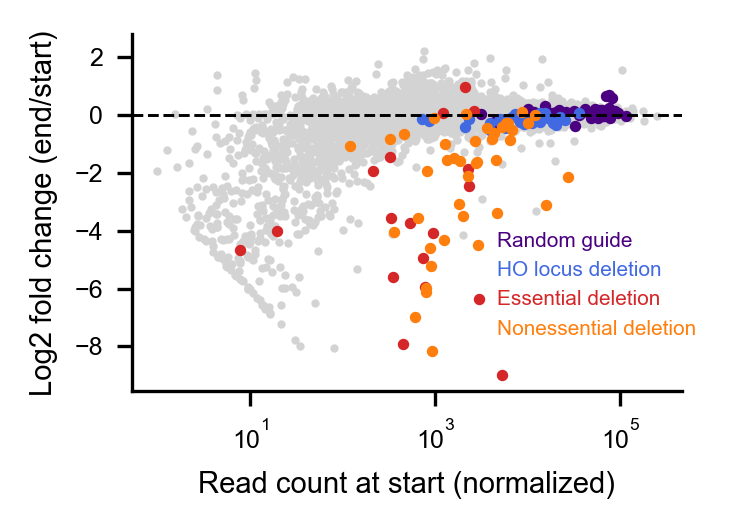

In [41]:
#Supplementary Figure
print('Controls for pooled competition')
print('padj is adjusted p-value that |l2fc| > 0.58')

PADJ_TH = 0.05 
L2FC_TH = 0
padj_m = 'comp_padj'
l2fc_m = 'comp_l2fc'
base_m = 'comp_baseMean'

fig, ax = plt.subplots(figsize=(6*cm,4*cm))

print('Keep only most significant variant')
db = comp[comp.variant.isin(['r','d','c','v'])].sort_values(by='comp_padj') 
db = db[(db.variant.isin(['r'])) | (~db.duplicated(subset=['gene','w_codon_num','old_window','new_window'], keep='first'))]

plt.scatter(db[base_m], db[l2fc_m], s=1, alpha=1, color='lightgrey', label='all synonymous variants')

conditions_del =  (db[padj_m] < PADJ_TH) & (db[l2fc_m] < - L2FC_TH)
conditions_adv = (db[padj_m] < PADJ_TH) & (db[l2fc_m] > L2FC_TH)

conditions = (db.control_type == 'random')
print("random variants", np.sum(conditions))
print("deleterious random", np.sum(conditions_del & conditions), 
      'advantageous', np.sum(conditions_adv & conditions))
plt.scatter(db[conditions][base_m], db[conditions][l2fc_m], s=3, color='indigo', label=f"random guides")

conditions = (db.control_type == 'HO_locus')
print("HO locus deletion variants", np.sum(conditions))
print("deleterious HO locus", np.sum(conditions_del & conditions), 
      'advantageous', np.sum(conditions_adv & conditions))
plt.scatter(db[conditions][base_m], db[conditions][l2fc_m], s=3, color='royalblue', label=f"HO locus deletion")

conditions = (db.control_type == 'essential')
print("essential deletions", np.sum(conditions))
print("deleterious essential deletions", np.sum(conditions_del & conditions), 
      'advantageous', np.sum(conditions_adv & conditions))
plt.scatter(db[conditions][base_m], db[conditions][l2fc_m], s=3, color='tab:red', label=f"essential deletion")

conditions = (db.control_type == 'nonessential_strong')
print("nonessential deletions - expected deleterious, growth defect > 2%", np.sum(conditions))
print("deleterious known growth defect deletions", np.sum(conditions_del & conditions), 
      'advantageous', np.sum(conditions_adv & conditions))
plt.scatter(db[conditions][base_m], db[conditions][l2fc_m], s=3, color='tab:orange', label=f"deletion (growth defect > 2%)")


plt.axhline(y=0, color='black', lw=0.7, ls='dashed') 

plt.xscale('log')
plt.xlabel('Read count at start (normalized)', fontsize=7)
plt.ylabel('Log2 fold change (end/start)', fontsize=7)

handles = [

    mlines.Line2D([],[],color='none', label='Random guide'),
    mlines.Line2D([],[],color='none', label='HO locus deletion'),
    mlines.Line2D([],[],color='none', label='Essential deletion'),
    mlines.Line2D([],[],color='none', label='Nonessential deletion'),
]


plt.legend(handles=handles, labelcolor=['indigo','royalblue','tab:red','tab:orange'], frameon=False, fontsize=5, framealpha=0.8, bbox_to_anchor=(0.6,0.5), handlelength=0)
ax.spines[['top','right']].set_visible(False)
plt.xticks([10,1000,100000], fontsize=6)
plt.yticks([-8,-6,-4,-2,0,2], fontsize=6)
plt.savefig(fig_dir+'supp_competition_controls.pdf', format='pdf', bbox_inches='tight')

plt.show()

Log2 fold change of pooled competition controls
Keep only most significant variant
random 42 significant 1 not significant 41
HO_locus 28 significant 0 not significant 28
essential 18 significant 15 not significant 3
nonessential_strong 44 significant 27 not significant 17


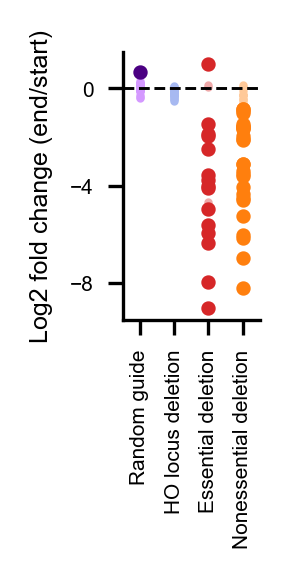

In [42]:
#Figure 4C
print('Log2 fold change of pooled competition controls')
PADJ_TH = 0.05 
L2FC_TH = 0
padj_m = 'comp_padj'
l2fc_m = 'comp_l2fc'
base_m = 'comp_baseMean'
fig, ax = plt.subplots(figsize=(1.5*cm,3*cm))
print('Keep only most significant variant')
db = comp[ comp.variant.isin(['r','d','c','v'])].sort_values(by='comp_padj') #.drop_duplicates(subset=['gene', 'w_codon_num'])
db = db[(db.variant.isin(['r'])) | (~db.duplicated(subset=['gene','w_codon_num','old_window','new_window'], keep='first'))]


colors = {'random':'indigo', 'HO_locus':'royalblue', 'essential':'tab:red', 'nonessential_strong':'tab:orange'}

for i, control in enumerate(['random', 'HO_locus', 'essential', 'nonessential_strong']):
    
    conditions = (db.control_type == control)
    sig = db[padj_m] < 0.05
    print(control, np.sum(conditions), 'significant', np.sum(conditions & sig), 'not significant', np.sum(conditions & ~ sig))
    plt.scatter([i]*np.sum(conditions & ~sig), db[conditions & ~sig][l2fc_m] , s=1, color=adjust_lightness(colors[control], 0.8), label=control)
    plt.scatter([i]*np.sum(conditions & sig), db[conditions & sig][l2fc_m], s=6, color=colors[control], label=control)


#plt.ylim(-20,5)
plt.xticks([0,1,2,3], ['Random guide', 'HO locus deletion', 'Essential deletion', 'Nonessential deletion'], rotation=90, fontsize=5)
plt.xlim(-0.5, 3.5)
plt.yticks([0,-4,-8], fontsize=5)
plt.ylabel('Log2 fold change (end/start)', fontsize=6)
plt.axhline(y=0, color='black', lw=0.7, ls='dashed') #, alpha=0.5)

ax.spines[['top','right']].set_visible(False)
plt.savefig(fig_dir + 'supp_controls_l2fc.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [43]:
comp[(comp.gene == 'YMR116C') & (comp.w_codon_num.isin([33,43]))].sort_values(by='comp_padj')#, 'comp_baseMean'], ascending=False)

,guide_seq,chrom,cut_pos,guide_strand,gene,gene_strand,w_codon_num,w_gene_pos,w_chrom_pos,w_size,old_window,new_window,wt_seq,donor,insert_seq,target,n_off_targets,edit_in_pam,edits_in_guide,edit_position,repeat_length,replicates,variant,comp_baseMean,comp_finalMean,comp_l2fc,comp_padj,gene_name,model_score,label,control_type
variant_YMR116C_129_guide_chrXIII_-_500559,GTGATAAGACTTTGATCTCC,chrXIII,500559.0,-,YMR116C,-,43.0,129.0,500556.0,3.0,TCC,TCG,CTGGTCAACCAAACCTATTGTTGTCCGCTTCCCGTGATAAGACTTT...,CTGGTCAACCAAACCTATTGTTGTCCGCTTCCCGTGATAAGACTTT...,GAGTTACTGTCTGTTTTCCTCTGGTCAACCAAACCTATTGTTGTCC...,YMR116C_43,0.0,False,1.0,-1.0,4.0,2.0,v,13235.752427,14371.501996,0.118771,1.0,ASC1,0.402457,1.0,not_control
variant_YMR116C_129_guide_chrXIII_+_500552,GTCGTCACCAGTCAACTTCC,chrXIII,500552.0,+,YMR116C,-,43.0,129.0,500556.0,3.0,TCC,TCG,CTTGAAAGATCTAACTGGGACACCAAACTTTTGGTCGTCACCAGTC...,CTTGAAAGATCTAACTGGGACACCAAACTTTTGGTCGTCACCAGTC...,GAGTTACTGTCTGTTTTCCTCTTGAAAGATCTAACTGGGACACCAA...,YMR116C_43,0.0,True,1.0,1.0,4.0,2.0,v,8623.133830,9521.337859,0.142952,1.0,ASC1,0.402457,1.0,not_control
variant_YMR116C_99_guide_chrXIII_+_500590,CACGGGAAGCGGACAACAAT,chrXIII,500590.0,+,YMR116C,-,33.0,99.0,500586.0,3.0,TTG,CTG,CACCAGTCAACTTCCAGGAGATCAAAGTCTTATCACGGGAAGCGGA...,CACCAGTCAACTTCCAGGAGATCAAAGTCTTATCACGGGAAGCGGA...,GAGTTACTGTCTGTTTTCCTCACCAGTCAACTTCCAGGAGATCAAA...,YMR116C_33,0.0,False,1.0,-5.0,3.0,1.0,v,5069.741486,5251.177258,0.050729,1.0,ASC1,0.400024,1.0,not_control
neutral_YMR116C_129_guide_chrXIII_+_500552,GTCGTCACCAGTCAACTTCC,chrXIII,500552.0,+,YMR116C,-,43.0,129.0,500556.0,3.0,TCC,TCT,CTTGAAAGATCTAACTGGGACACCAAACTTTTGGTCGTCACCAGTC...,CTTGAAAGATCTAACTGGGACACCAAACTTTTGGTCGTCACCAGTC...,GAGTTACTGTCTGTTTTCCTCTTGAAAGATCTAACTGGGACACCAA...,YMR116C_43,0.0,True,1.0,1.0,4.0,2.0,n,2527.441984,2735.073823,0.113902,1.0,ASC1,0.402457,1.0,not_control
neutral_YMR116C_129_guide_chrXIII_-_500559,GTGATAAGACTTTGATCTCC,chrXIII,500559.0,-,YMR116C,-,43.0,129.0,500556.0,3.0,TCC,TCT,CTGGTCAACCAAACCTATTGTTGTCCGCTTCCCGTGATAAGACTTT...,CTGGTCAACCAAACCTATTGTTGTCCGCTTCCCGTGATAAGACTTT...,GAGTTACTGTCTGTTTTCCTCTGGTCAACCAAACCTATTGTTGTCC...,YMR116C_43,0.0,False,1.0,-1.0,4.0,2.0,n,11582.248023,11868.423163,0.035213,1.0,ASC1,0.402457,1.0,not_control


Variants that are present in Shen et al.
padj is adjusted p-value that |l2fc| > 0.58
Keep only most significant variant
ASC1 43 TCC to TCG p-value 1.0
ASC1 43 TCC to TCT p-value 1.0
ASC1 33 TTG to CTG p-value 1.0


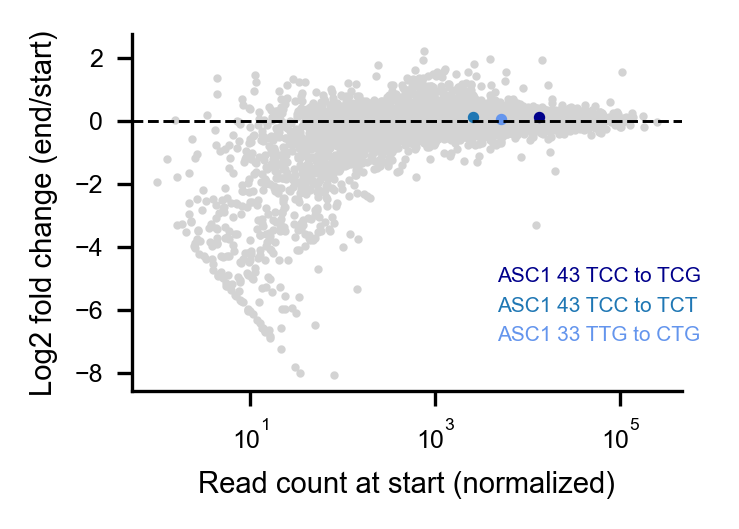

In [45]:
#Unused version of Figure 4C
print('Variants that are present in Shen et al.')
print('padj is adjusted p-value that |l2fc| > 0.58')


variants = {'variant_YMR116C_129_guide_chrXIII_-_500559':'ASC1 43 TCC to TCG', 'neutral_YMR116C_129_guide_chrXIII_+_500552':'ASC1 43 TCC to TCT', 'variant_YMR116C_99_guide_chrXIII_+_500590':'ASC1 33 TTG to CTG'}
colors = {'ASC1 43 TCC to TCG':'darkblue', 'ASC1 43 TCC to TCT':'tab:blue', 'ASC1 33 TTG to CTG':'cornflowerblue'}

PADJ_TH = 0.05 
L2FC_TH = 0
padj_m = 'comp_padj'
l2fc_m = 'comp_l2fc'
base_m = 'comp_baseMean'

fig, ax = plt.subplots(figsize=(6*cm,4*cm))

print('Keep only most significant variant')
db = comp[(comp.variant == 'v')].sort_values(by='comp_padj').drop_duplicates(subset=['gene', 'w_codon_num'])
plt.scatter(db[base_m], db[l2fc_m], s=1, alpha=1, color='lightgrey', label='all synonymous variants')

plt.axhline(y=0, color='black', lw=0.7, ls='dashed') 


handles = []
labelcolors=[]
for v in variants.keys():
    print(variants[v], 'p-value', comp[padj_m][v])
    plt.scatter(comp[base_m][v], comp[l2fc_m][v], s=3, color=colors[variants[v]])
    handles.append(mlines.Line2D([],[],color='none', label=variants[v]))
    labelcolors.append(colors[variants[v]])



plt.xscale('log')
plt.xlabel('Read count at start (normalized)', fontsize=7)
plt.ylabel('Log2 fold change (end/start)', fontsize=7)


plt.legend(handles=handles, labelcolor=labelcolors, frameon=False, fontsize=5, framealpha=0.8, bbox_to_anchor=(0.6,0.4), handlelength=0)
ax.spines[['top','right']].set_visible(False)
plt.xticks([10,1000,100000], fontsize=6)
plt.yticks([-8,-6,-4,-2,0,2], fontsize=6)
plt.savefig(fig_dir+'supp_shen_variants.pdf', format='pdf', bbox_inches='tight')

plt.show()

NO significant difference between "fast-to-slow or slow-to-fast" and "slow-to-slow or fast-to-fast" variants


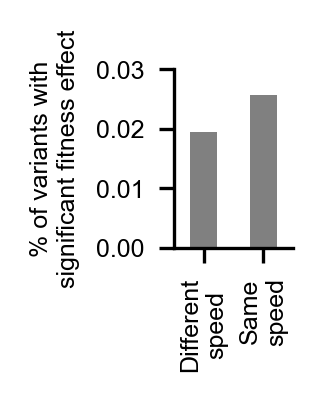

zscore n vs v 1.4160740054511807


In [46]:
#Unused Supplementary Figure
print('NO significant difference between "fast-to-slow or slow-to-fast" and "slow-to-slow or fast-to-fast" variants')

fig, ax = plt.subplots(figsize=(1.3*cm,2*cm))


comp_df = comp[comp.variant.isin(['n','v'])]
#drop duplicate guides - keep strongest p-value
comp_df = comp_df.sort_values(by='comp_padj').drop_duplicates(subset=['gene','w_codon_num','old_window','new_window'], keep='first')
#and remove all positions except those that have both a speed-change and same-speed mutation
comp_df = comp_df[comp_df.duplicated(subset=['gene', 'w_codon_num', 'old_window'], keep=False)]

names = ['Different\nspeed', 'Same\nspeed']
conditions = [(comp_df.variant == 'v'), (comp_df.variant == 'n')]
sig = comp_df['comp_padj'] < 0.05
p_sig = [np.sum(sig & c)/np.sum(c) for c in conditions]


plt.bar(names, p_sig, width=0.45, color='gray')
plt.yticks([0,0.01,0.02,0.03],fontsize=6)
plt.xticks(fontsize=6, rotation=90)
plt.ylabel('% of variants with\nsignificant fitness effect',fontsize=6)
ax.spines[['top','right']].set_visible(False)
plt.xlim([-0.5,1.5])
plt.savefig(fig_dir+'supp_speed_percent_fitness_effect.pdf', format='pdf', bbox_inches='tight')
plt.show()

print('zscore n vs v', zscore(np.sum( (comp_df.variant == 'n')),
            np.sum( (comp_df.variant == 'n') & sig),
             np.sum( (comp_df.variant == 'v')) ,
            np.sum( (comp_df.variant == 'v') & sig),
             ))


In [47]:
#Considering speed-change and no-speed change variants individually by codon
comp_df = comp[comp.variant.isin(['n','v'])]
#drop duplicate guides - keep strongest padj
comp_df = comp_df.sort_values(by='comp_padj').drop_duplicates(subset=['gene','w_codon_num','old_window','new_window'], keep='first')
#and remove all positions except those that have a neutral and a variant
comp_df = comp_df[comp_df.duplicated(subset=['gene', 'w_codon_num', 'old_window'], keep=False)]

codons_w_n = list(comp_df.old_window.unique())
change_dict = {}
for c in codons_w_n:
    change_dict[c] = {}
    if len(comp_df[(comp_df.old_window == c) & comp_df.variant.isin(['n'])].new_window.unique()) != 1:
        codons_w_n.remove(c)
        print(c, 'n')
        continue
    change_dict[c]['neutral'] = comp_df[(comp_df.old_window == c) & comp_df.variant.isin(['n'])].new_window.unique()[0]
    if len(comp_df[(comp_df.old_window == c) & comp_df.variant.isin(['v'])].new_window.unique()) != 1:
        codons_w_n.remove(c)
        print(c, 'v')
        continue
    change_dict[c]['variant'] = comp_df[(comp_df.old_window == c) & comp_df.variant.isin(['v'])].new_window.unique()[0]
change_dict

comp_df = comp_df

change_stats = {}
for c in change_dict:
    change_stats[c] = {}
    db = comp_df[(comp_df.old_window == c)]
    sig = (db.comp_padj < 0.05)
    change_stats[c]['fast'] = comp_df[comp_df.old_window == c].label.unique()[0]
    change_stats[c]['AA'] = codon_info.AA[c]
    change_stats[c]['n_change']= change_dict[c]['neutral']
    change_stats[c]['num_pos_n'] = np.sum(db.new_window == change_dict[c]['neutral'])
    change_stats[c]['num_sig_n']  = np.sum((db.new_window == change_dict[c]['neutral']) & sig)
    change_stats[c]['percent_significant_n'] =  change_stats[c]['num_sig_n'] / change_stats[c]['num_pos_n']
    change_stats[c]['v_change'] = change_dict[c]['variant']
    change_stats[c]['num_pos_v'] = np.sum(db.new_window == change_dict[c]['variant'])
    change_stats[c]['num_sig_v']  = np.sum((db.new_window == change_dict[c]['variant']) & sig)
    change_stats[c]['percent_significant_v'] =  change_stats[c]['num_sig_v'] / change_stats[c]['num_pos_v']
    change_stats[c]['zscore_percent_significant'] = zscore(change_stats[c]['num_pos_v'],change_stats[c]['num_sig_v'], change_stats[c]['num_pos_n'],change_stats[c]['num_sig_n'])
    change_stats[c]['pval_percent_significant'] = scipy.stats.norm.sf(np.abs(change_stats[c]['zscore_percent_significant']))*2 
    
change_stats = pd.DataFrame(change_stats).T

change_stats.sort_values(by=['fast','zscore_percent_significant'], ascending=[True,False])


,fast,AA,n_change,num_pos_n,num_sig_n,percent_significant_n,v_change,num_pos_v,num_sig_v,percent_significant_v,zscore_percent_significant,pval_percent_significant
GGA,0,GLY,GGC,249,2,0.00803213,GGT,249,11,0.0441767,2.52938,0.0114263
TCG,0,SER,AGC,153,0,0,TCT,153,2,0.0130719,1.41886,0.15594
GGC,0,GLY,GGA,236,4,0.0169492,GGT,236,6,0.0254237,0.639264,0.522651
CGA,0,ARG,CGG,118,6,0.0508475,AGA,118,6,0.0508475,0,1
CGG,0,ARG,CGA,176,3,0.0170455,AGA,176,2,0.0113636,-0.450424,0.652405
AGC,0,SER,TCG,132,1,0.00757576,TCT,132,0,0,-1.0019,0.316392
CCA,1,PRO,CCT,106,7,0.0660377,CCG,106,5,0.0471698,-0.594418,0.552232
CCT,1,PRO,CCA,143,4,0.027972,CCG,143,2,0.013986,-0.825198,0.409259
GCC,1,ALA,GCT,263,3,0.0114068,GCG,263,1,0.00380228,-1.00382,0.315463
TCT,1,SER,TCC,168,10,0.0595238,TCG,168,4,0.0238095,-1.63806,0.10141


Keep only most significant guide
Slow-to-fast positions only
number del 66 adv 27
mw del vs adv MannwhitneyuResult(statistic=650.0, pvalue=0.02089633233046033)

Median of del 0.443608965
Median of adv 0.5752352


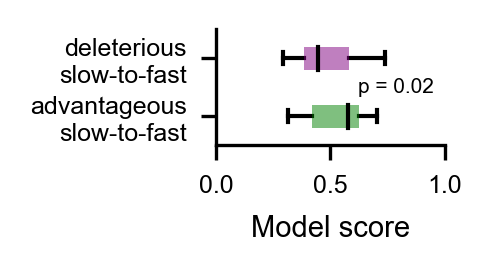

In [48]:
#Figure 4E
#Slow positions where a slow-to-fast mutation was deleterious had significantly lower model
#scores compared to slow positions where a slow-to-fast mutation was advantageous
m= "model_score"

print('Keep only most significant guide')
r_ = comp[(comp.variant == 'v')].sort_values(by='comp_padj').drop_duplicates(subset='target', keep='first')

print('Slow-to-fast positions only')
bg = (r_.variant == 'v') & (r_.label == 0) & (~r_.model_score.isna()) #slow to fast 

cond_del = (r_['comp_padj'] < 0.05) & (r_['comp_l2fc'] < 0) & bg

cond_adv = (r_['comp_padj'] < 0.05) & (r_['comp_l2fc'] > 0) & bg

print('number del', np.sum(cond_del), 'adv', np.sum(cond_adv))
print('mw del vs adv', scipy.stats.mannwhitneyu(r_[cond_del][m], r_[cond_adv][m]))
print()
print('Median of del', np.median(r_[cond_del][m]))
print('Median of adv', np.median(r_[cond_adv][m]))


u_stat, p_value = scipy.stats.mannwhitneyu(r_[cond_del][m], r_[cond_adv][m])

fig, ax = plt.subplots(figsize=(2.5*cm,1.3*cm)) #, dpi=200)
box = ax.boxplot([r_[cond_adv][m], r_[cond_del][m]], labels=["advantageous\nslow-to-fast", "deleterious\nslow-to-fast"], patch_artist=True, vert=False, widths=0.4)

box['boxes'][0].set(facecolor='green',alpha=0.5, edgecolor=None) 
box['boxes'][1].set(facecolor='purple', alpha=0.5, edgecolor=None)    

text_x = 0.95
text_y=0.5
ax.text(
    text_x, text_y,  
    f"p = {p_value:.2f}",
    fontsize=5, ha='right', va='center', transform=ax.transAxes, 
)

for median in box['medians']:
    median.set(color='black', linewidth=1, alpha=1) 
for whisker in box['whiskers']:
    whisker.set(linewidth=1, alpha=1)  
for cap in box['caps']:
    cap.set(linewidth=1, alpha=1)  
for box_element in box['boxes']:
    box_element.set(linewidth=0)

ax.set_xlabel("Model score", fontsize=7)
plt.yticks(fontsize=6)
plt.xticks([0,0.5,1],fontsize=6)
plt.xlim(0,1)
ax.spines[['top','right']].set_visible(False)
plt.savefig(fig_dir + 'correspondence_slow_to_fast.pdf', format='pdf', bbox_inches='tight')
plt.show()


Keep only most significant guide
Fast-to-slow positions only, exclude any positions where AA is not in model
num del 72 adv 42
mw del vs adv MannwhitneyuResult(statistic=1475.0, pvalue=0.41511393439781175)

Median of del 0.5750404600000001
Median of adv 0.5793648250000001


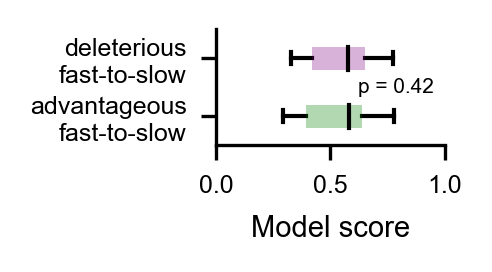

In [49]:
#Unused Supplementary Figure
m= "model_score"

print('Keep only most significant guide')
r_ = comp[(comp.variant == 'v')].sort_values(by='comp_padj').drop_duplicates(subset='target', keep='first')

print('Fast-to-slow positions only, exclude any positions where AA is not in model')
bg = (r_.variant == 'v') & (r_.label == 1) & (~r_.model_score.isna()) #slow to fast 

cond_del = (r_['comp_padj'] < 0.05) & (r_['comp_l2fc'] < 0) & bg

cond_adv = (r_['comp_padj'] < 0.05) & (r_['comp_l2fc'] > 0) & bg

print('num del', np.sum(cond_del), 'adv', np.sum(cond_adv))
print('mw del vs adv', scipy.stats.mannwhitneyu(r_[cond_del][m], r_[cond_adv][m]))
print()
print('Median of del', np.median(r_[cond_del][m]))
print('Median of adv', np.median(r_[cond_adv][m]))


u_stat, p_value = scipy.stats.mannwhitneyu(r_[cond_del][m], r_[cond_adv][m])

fig, ax = plt.subplots(figsize=(2.5*cm,1.3*cm)) #, dpi=200)
box = ax.boxplot([r_[cond_adv][m], r_[cond_del][m]], labels=["advantageous\nfast-to-slow", "deleterious\nfast-to-slow"], patch_artist=True, vert=False, widths=0.4)

box['boxes'][0].set(facecolor='green',alpha=0.3, edgecolor=None) 
box['boxes'][1].set(facecolor='purple', alpha=0.3, edgecolor=None)    

text_x = 0.95
text_y=0.5
ax.text(
    text_x, text_y,  
    f"p = {p_value:.2f}",
    fontsize=5, ha='right', va='center', transform=ax.transAxes, 
)

for median in box['medians']:
    median.set(color='black', linewidth=1, alpha=1) 
for whisker in box['whiskers']:
    whisker.set(linewidth=1, alpha=1)  
for cap in box['caps']:
    cap.set(linewidth=1, alpha=1)  
for box_element in box['boxes']:
    box_element.set(linewidth=0)

ax.set_xlabel("Model score", fontsize=7)
plt.yticks(fontsize=6)
plt.xticks([0,0.5,1],fontsize=6)
plt.xlim(0,1)
ax.spines[['top','right']].set_visible(False)
plt.savefig(fig_dir + 'supp_no_correspondence_fast_to_slow.pdf', format='pdf', bbox_inches='tight')
plt.show()

/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/lareaulab/shelen/anaconda3/envs/gen_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


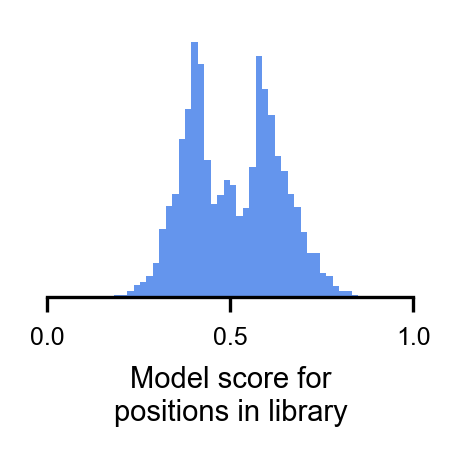

In [50]:
#Unused Supplementary Figure - distribution of model scores in target positions in library
fig, ax = plt.subplots(figsize=(4*cm,3*cm)) 
plt.hist(comp.model_score, bins=40, density=True, color='cornflowerblue')
plt.xlabel('Model score for\npositions in library',fontsize=7)
plt.xticks([0,0.5,1], fontsize=6)
plt.yticks([])
plt.xlim([0,1])
ax.spines[['top','left','right']].set_visible(False)
plt.savefig(fig_dir + 'supp_library_score_distribution.pdf', format='pdf', bbox_inches='tight')

plt.show()